# This experiment/notebook is to analyze experiment SD613 - live imaging of Nwk-HALO and BRP-mimic

## Outline

# Imports, load data, set options

In [65]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os
import Aggregate_PAZ_Data as agg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import hmean
from sklearn.neighbors import KernelDensity as kde
from sklearn.model_selection import GridSearchCV
from scipy.stats import kstest, kruskal, f_oneway as anova
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import scikit_posthocs as ph
import importlib
import libpysal
import pointpats as pp
import CentroidAnalysis as ca
import tifffile as tf

In [85]:
# Basic info about experiment
version_num = "218"
experiment_num = "Example"
root_dir = "C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\SingleDescriptive\\"
#root_dir = "C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\MultiDescriptive\\"
savepath = f"C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\ExampleSingleCompiled\\"
statspath = os.path.join(savepath, "Stats")

# Use data order to set the order that channels will appear on graphs. 
data_order = ["DYN", "NWK"]


In [ ]:
# Set graphing style and options
ax_params = {"axes.spines.right": False, "axes.spines.top": False, "figure.dpi": 300, "savefig.dpi":300}
sns.set_theme(style="ticks", rc=ax_params)
sns.set_context('paper', font_scale=2)
c_palette="muted"
sns.set_palette(c_palette)

In [ ]:
# Create folders
if not os.path.isdir(savepath):
    os.mkdir(savepath)

if not os.path.isdir(statspath):
    os.mkdir(statspath)


## Load raw data into dataframes

In [67]:
# Load composite mesh based PAZ data
CompMesh = agg.aggregate_csvs(root_dir, version_num, "Comp_ALLTHECELLS.csv")

# Load BRP based 'PAZ' data 
AZMesh = agg.aggregate_csvs(root_dir, version_num, "BRP_ALLTHECELLS.csv")

# Add new column to mesh datasets to denote NMJs instead of images
CompMesh['nmjid'] = CompMesh['Image'].str.split("Out-", expand=True)[0]
AZMesh['nmjid'] = AZMesh['Image'].str.split("Out-", expand=True)[0]

# Filter out all mesh units with mean EDM <=7.5
CompMeshF = CompMesh.loc[CompMesh.EDMmean>=7.5, :]
AZMeshF = AZMesh.loc[AZMesh.EDMmean>=7.5, :]

# Filter out mesh units without AZ
CompMeshF_AZ = CompMeshF.loc[CompMeshF.AZcount>0, :]
Composite_1AZ=CompMesh[CompMesh.AZcount==1]

# Load whole NMJ data
wholeNMJ = agg.aggregate_csvs(root_dir, version_num, "NMJ_Data.csv")


In [68]:
# This is what the dataframe looks like
CompMesh

,Experiment,Image,AZcount,AZidtotal,AZareatotal,Area,Circ.,EDMmin,EDMmean,CoreArea,...,CoreLoGrms_NWK,MeshMean_NWK,MeshCoV_NWK,MeshLoGrms_NWK,MeshRatio_NWK,EntrD2_NWK,EntrD4_NWK,EntrD6_NWK,EntrD8_NWK,nmjid
0,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,2.0,0.28961,0.14597,0.35520,0.48737,1.0,3.19863,0.05596,...,0.99691,1.09079,0.24073,1.10719,1.30777,5.3188,5.3559,5.3265,5.3683,SD555_5mm_L1_m4_2020_12_06__09_42_45_
1,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,1.0,0.08084,0.11678,0.19463,0.74935,1.0,3.52500,0.03406,...,0.71516,1.25789,0.42720,1.58119,1.27668,4.8304,4.8087,4.8520,4.8087,SD555_5mm_L1_m4_2020_12_06__09_42_45_
2,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,0.0,0.00000,0.00000,0.34790,0.81800,5.0,11.63636,0.11435,...,1.07126,1.31314,0.37558,1.86079,2.98599,5.1469,5.1469,5.1311,5.1469,SD555_5mm_L1_m4_2020_12_06__09_42_45_
3,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,1.0,0.04001,0.05109,0.09002,0.83791,0.0,1.94595,0.02676,...,0.78983,1.11038,0.21152,1.16541,1.38294,4.3356,4.4301,4.3394,4.3394,SD555_5mm_L1_m4_2020_12_06__09_42_45_
4,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,1.0,0.02870,0.02919,0.12408,0.73363,4.0,7.33333,0.00487,...,0.84229,0.99409,0.19635,1.20064,1.97989,4.4877,4.5511,4.4578,4.4711,SD555_5mm_L1_m4_2020_12_06__09_42_45_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Example,SD555_5mm_L4__2020_12_06__13_44_30_Out-1_MaxZ9...,0.0,0.00000,0.00000,0.07542,0.79457,1.0,2.41935,0.01946,...,1.85843,1.57245,0.36700,2.30591,1.55620,4.3647,4.3127,4.3820,4.2303,SD555_5mm_L4__2020_12_06__13_44_30_
276,Example,SD555_5mm_L4__2020_12_06__13_44_30_Out-1_MaxZ9...,2.0,0.38175,0.15570,0.46955,0.82304,1.0,5.90155,0.19950,...,1.88277,1.46786,0.47803,2.57162,1.62181,5.3042,5.3042,5.2842,5.3242,SD555_5mm_L4__2020_12_06__13_44_30_
277,Example,SD555_5mm_L4__2020_12_06__13_44_30_Out-1_MaxZ9...,0.0,0.00000,0.00000,0.11678,0.79434,1.0,3.37500,0.00730,...,1.39000,1.07365,0.45334,1.71117,2.94365,4.4633,4.4921,4.5066,4.5066,SD555_5mm_L4__2020_12_06__13_44_30_
278,Example,SD555_5mm_L4__2020_12_06__13_44_30_Out-1_MaxZ9...,1.0,0.06103,0.03893,0.03163,0.84558,1.0,1.53846,0.03163,...,2.03147,1.83383,0.33550,3.10022,1.02139,3.6582,3.6897,3.6582,3.5084,SD555_5mm_L4__2020_12_06__13_44_30_


# Colocalization analyses

## Whole NMJ colocalization

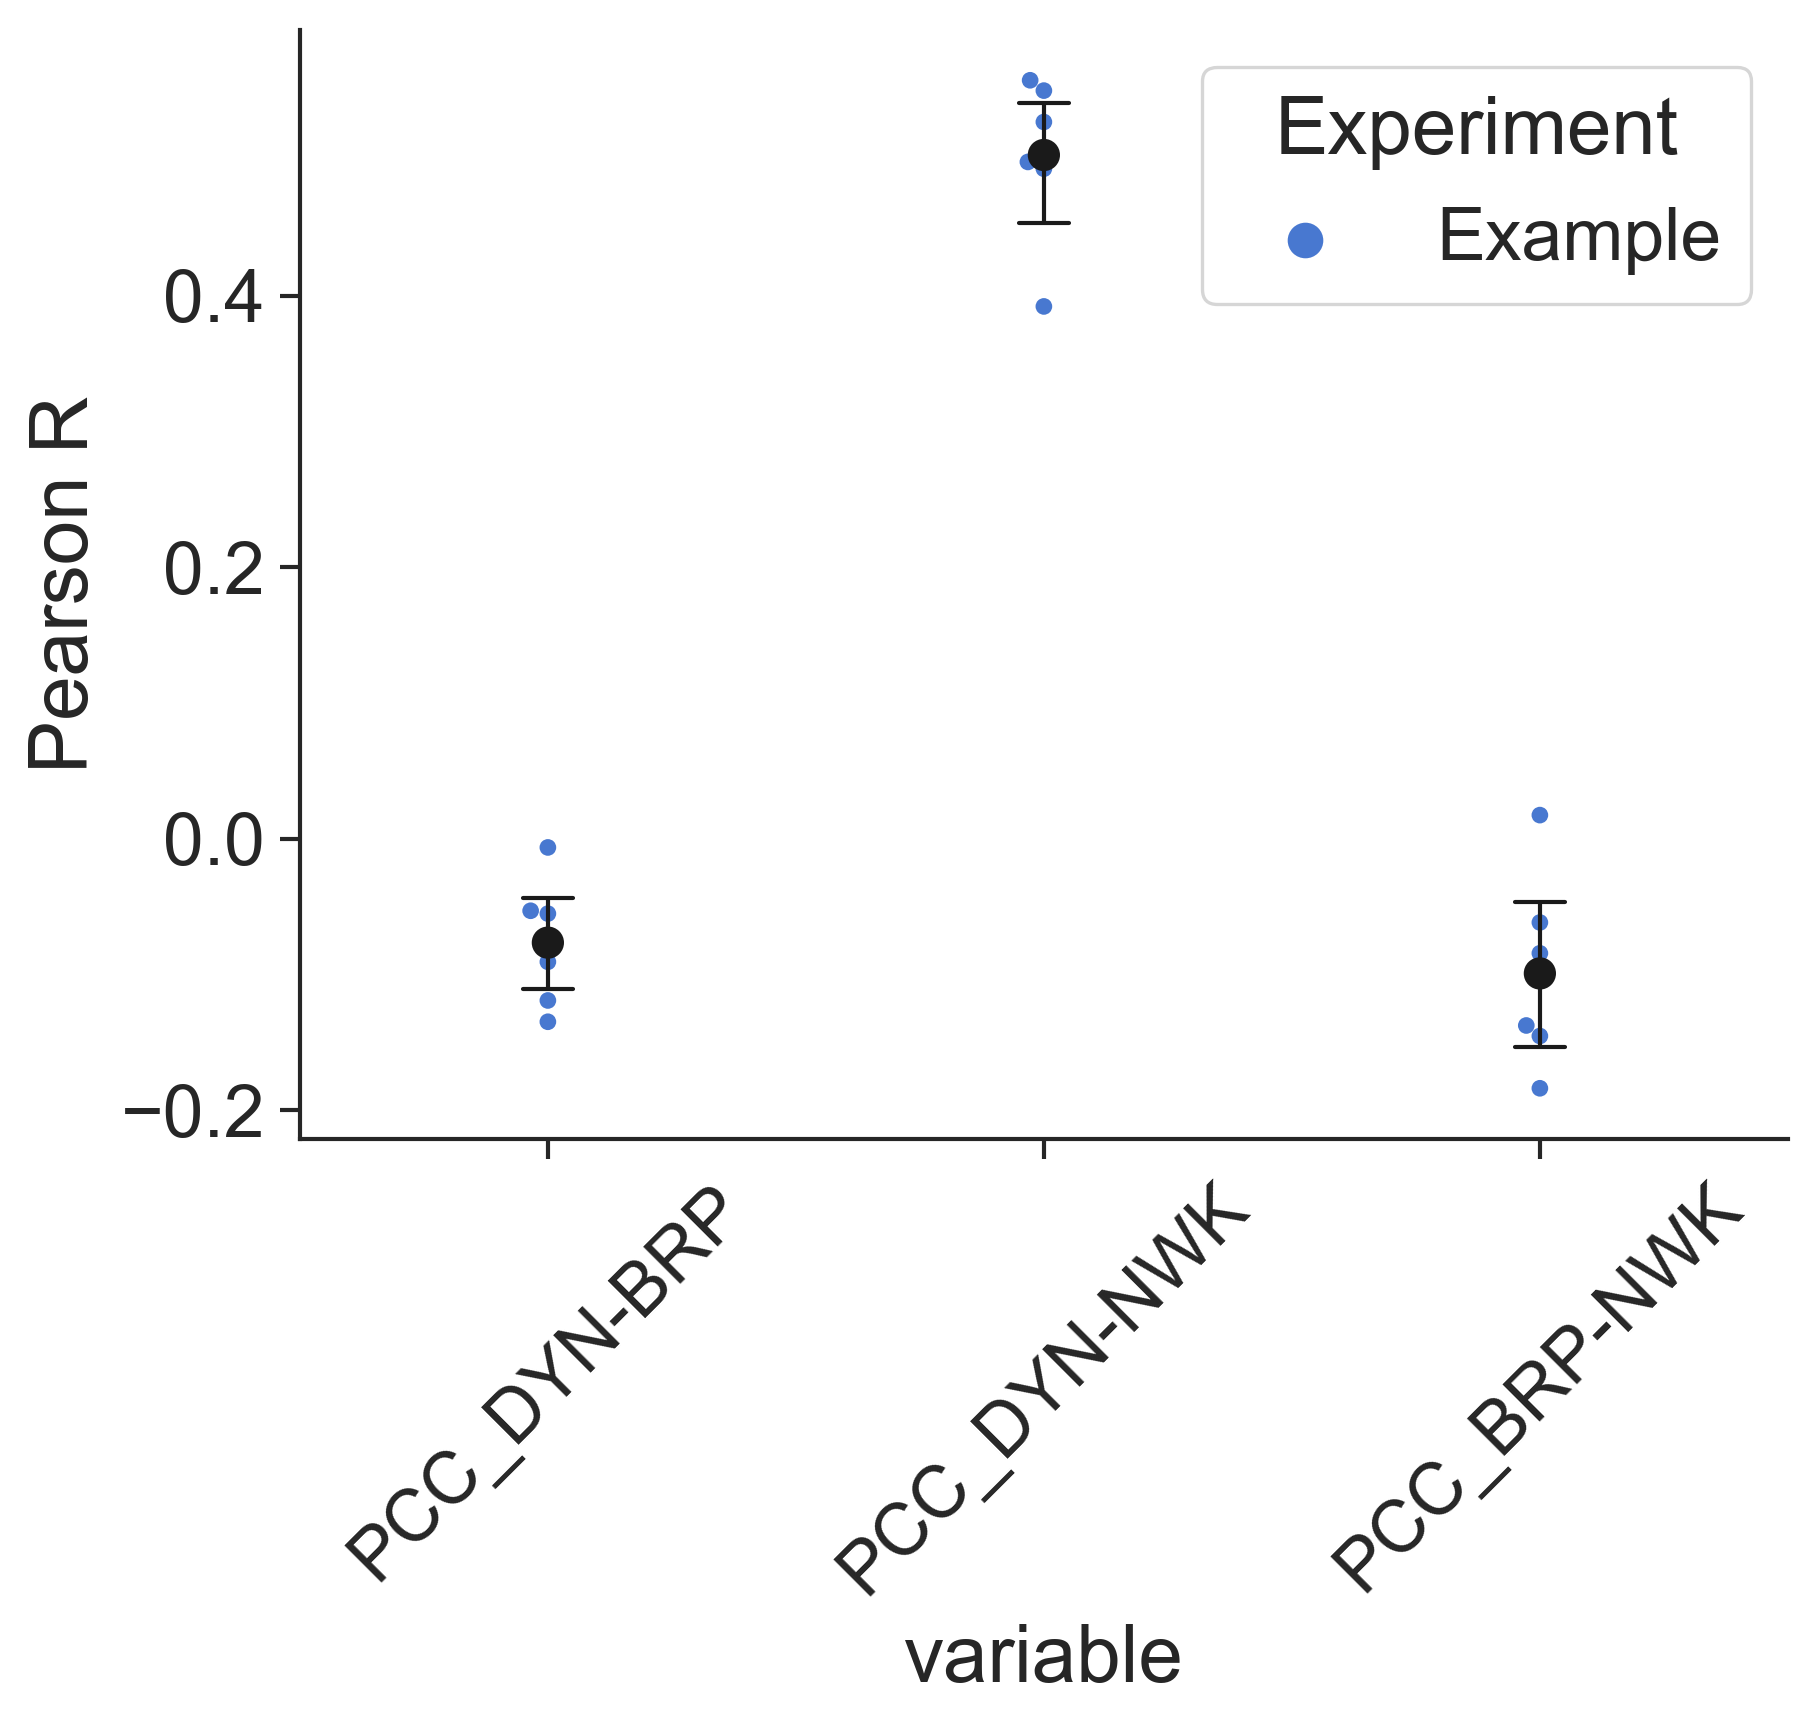

In [69]:
# Examine colocalization across whole NMJ
FIG="WholeNMJ_PAZ-PCC"

# The example below creates a graph showing all PCC comparisons. To show only PAZ-PAZ or only AZ-PAZ correlations, 
# substitute the appropriate ordering vector below into the order=**ordering vector** parameter in both plotting 
# commands below


# ordering vector for ALL PCC comparisons
pcc_order = wholeNMJ.columns[wholeNMJ.columns.str.contains("PCC")]

# ordering vector for only PAZ-PAZ comparisons
pcc_NoBRP = [i for i in pcc_order if "BRP" not in i]

# ordering vector for only AZ-PAZ comparisons
pcc_BRP = [i for i in pcc_order if "BRP" in i]

ExpMean = wholeNMJ.groupby("Experiment").mean().reset_index()

# Melt for plotting
ImgMean = wholeNMJ.drop("Image", axis=1).melt(id_vars=["Experiment"], value_name="Pearson R")

# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="Pearson R", 
                   size=4, order=pcc_order, hue="Experiment", zorder=0)

sns.pointplot(data=ImgMean, x="variable", y="Pearson R", order=pcc_order,
            palette=['k'], scale=1.1,
            join=False, capsize=.1, errwidth=1, ax=sp)

# Tweak formatting and save figure
plt.xticks(rotation=45)
plt.savefig(os.path.join(savepath, FIG+".svg"))
None

## Mesh and Core based colocalization

In [70]:
# ordering vector for ALL PCC comparisons
Meshpcc_order = CompMeshF_AZ.columns[CompMeshF_AZ.columns.str.contains("MeshPCC")]
Corepcc_order = CompMeshF_AZ.columns[CompMeshF_AZ.columns.str.contains("CorePCC")]

# ordering vector for only PAZ-PAZ comparisons
Meshpcc_NoBRP = [i for i in Meshpcc_order if "BRP" not in i]
Corepcc_NoBRP = [i for i in Corepcc_order if "BRP" not in i]

# ordering vector for only AZ-PAZ comparisons
Meshpcc_BRP = [i for i in Meshpcc_order if "BRP" in i]
Corepcc_BRP = [i for i in Corepcc_order if "BRP" in i]

# Create a melted dataframe containing only PCC columns and 'Experiment'
PCCs = CompMeshF_AZ.groupby(["Experiment", "nmjid"]).mean().reset_index()
PCCs = PCCs.melt(id_vars=["Experiment"], value_name="Pearson R")
PCCs = PCCs.loc[PCCs.variable.str.contains("PCC"), :]


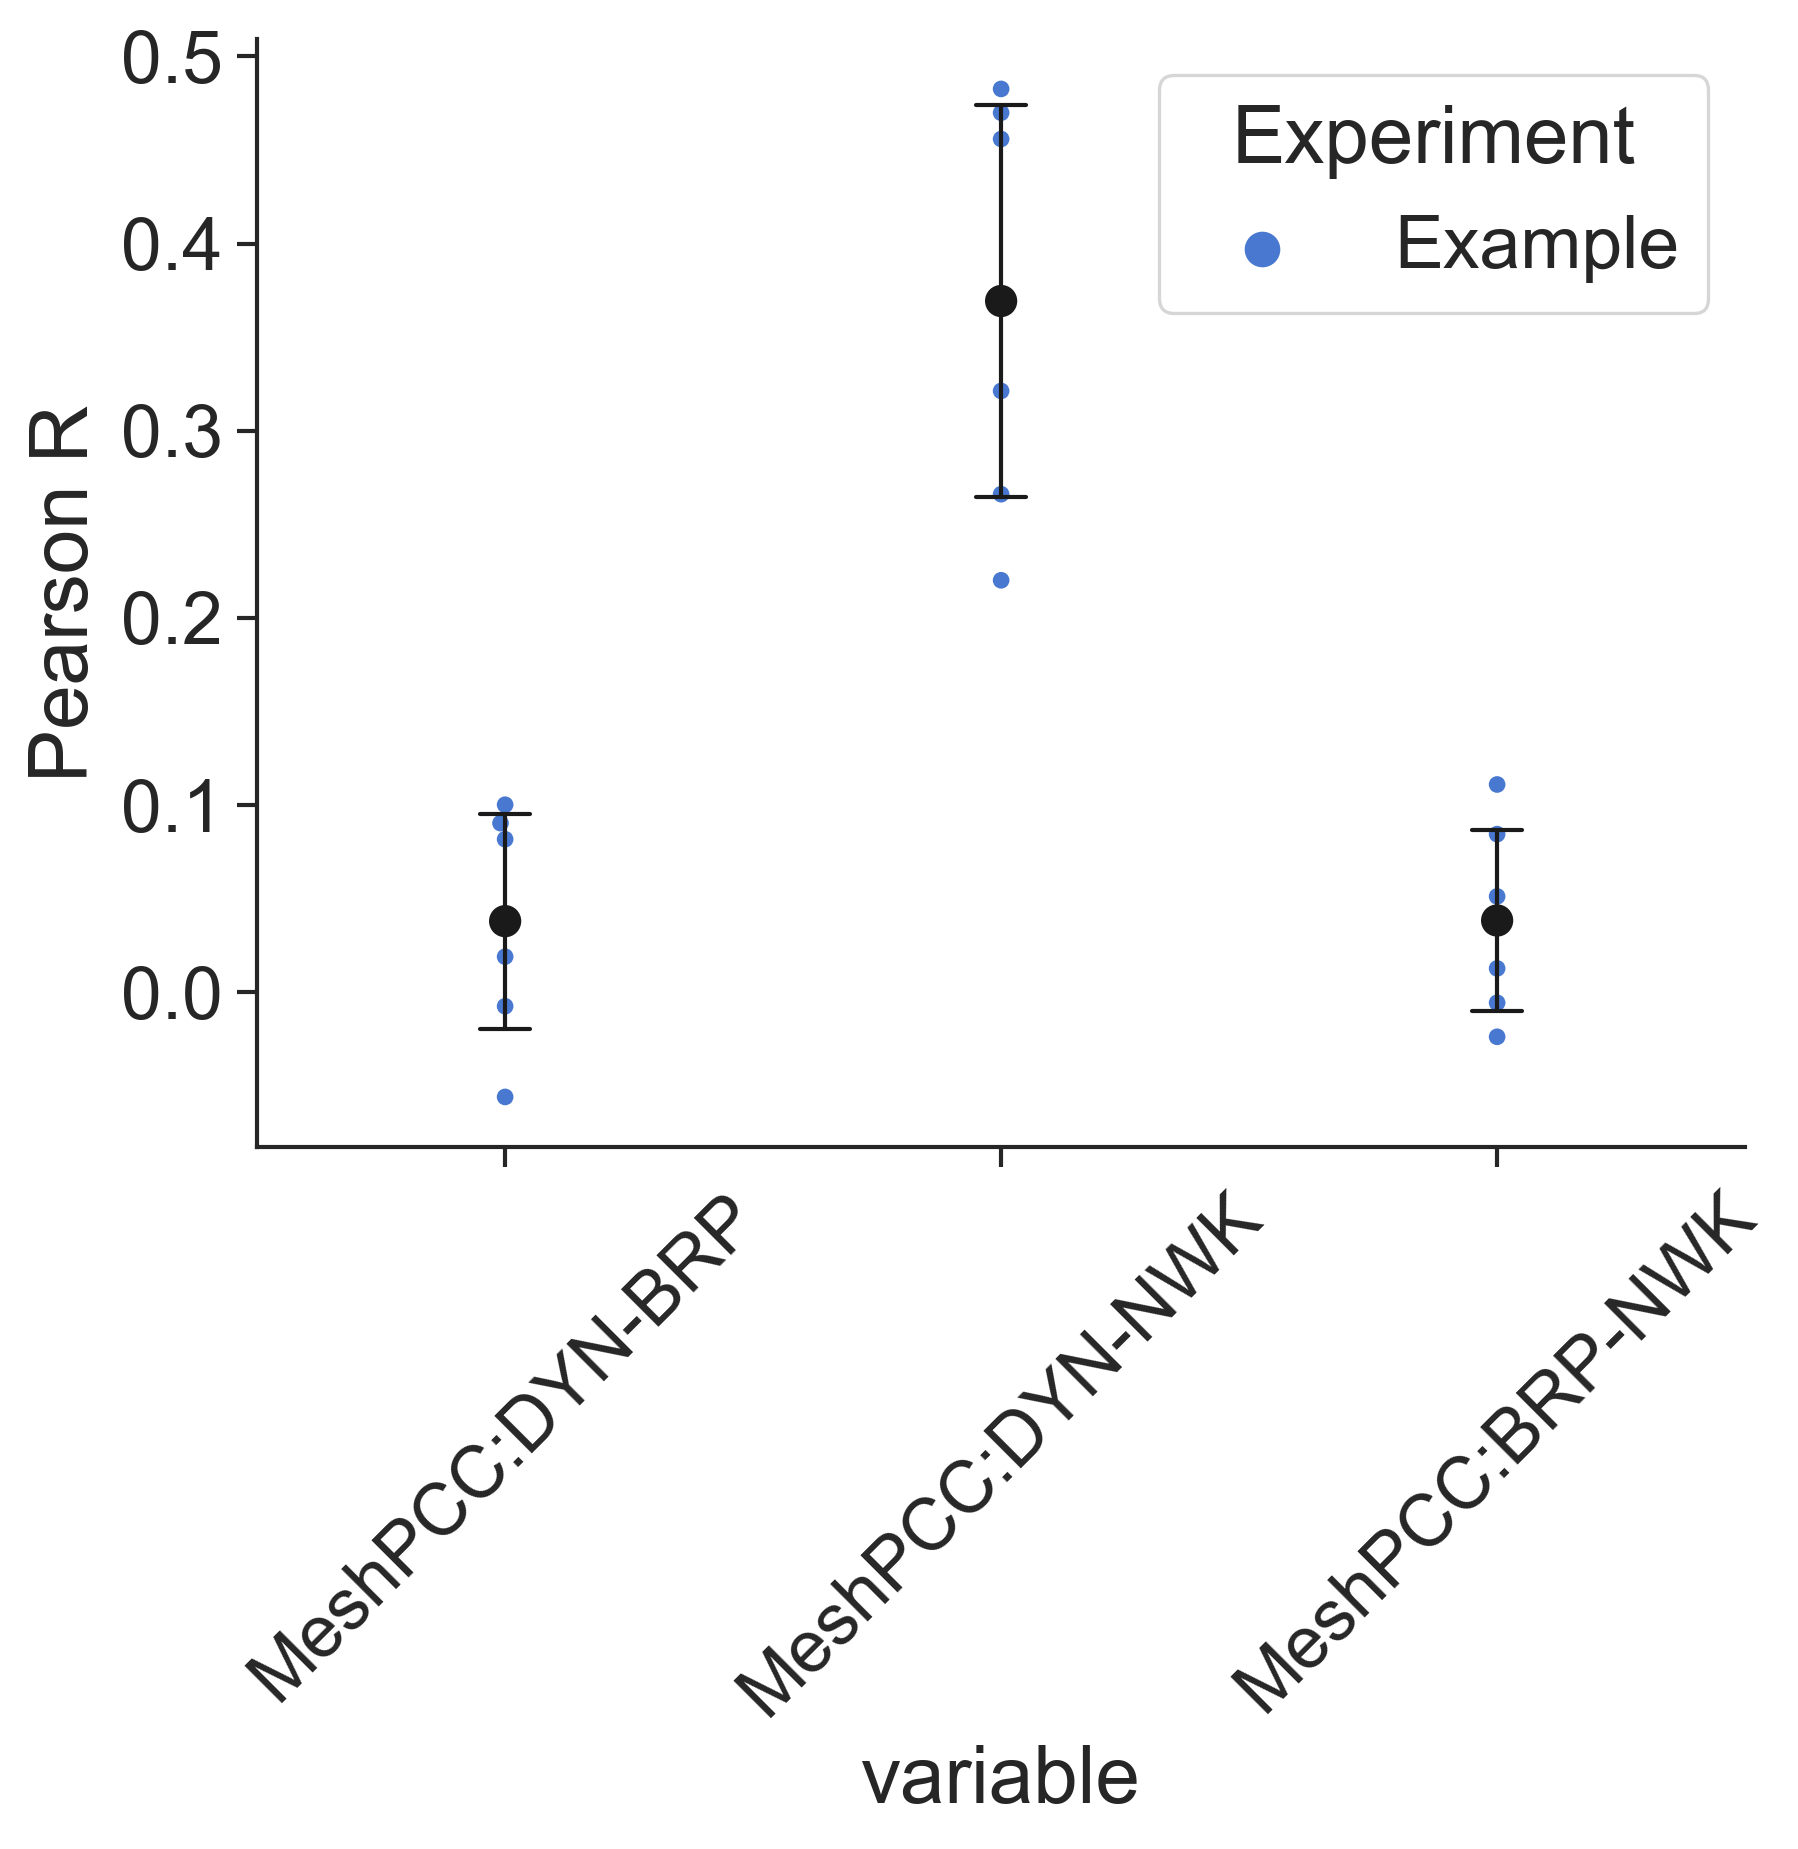

In [71]:
FIG = "MeshPCC"

# Plot
sp = sns.swarmplot(data=PCCs, x="variable", y="Pearson R", hue="Experiment",
                   size=4, order=Meshpcc_order, zorder=0)

sns.pointplot(data=PCCs, x="variable", y="Pearson R",
              order=Meshpcc_order, ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

plt.xticks(rotation=45)
plt.savefig(os.path.join(savepath, FIG+".svg"))
None

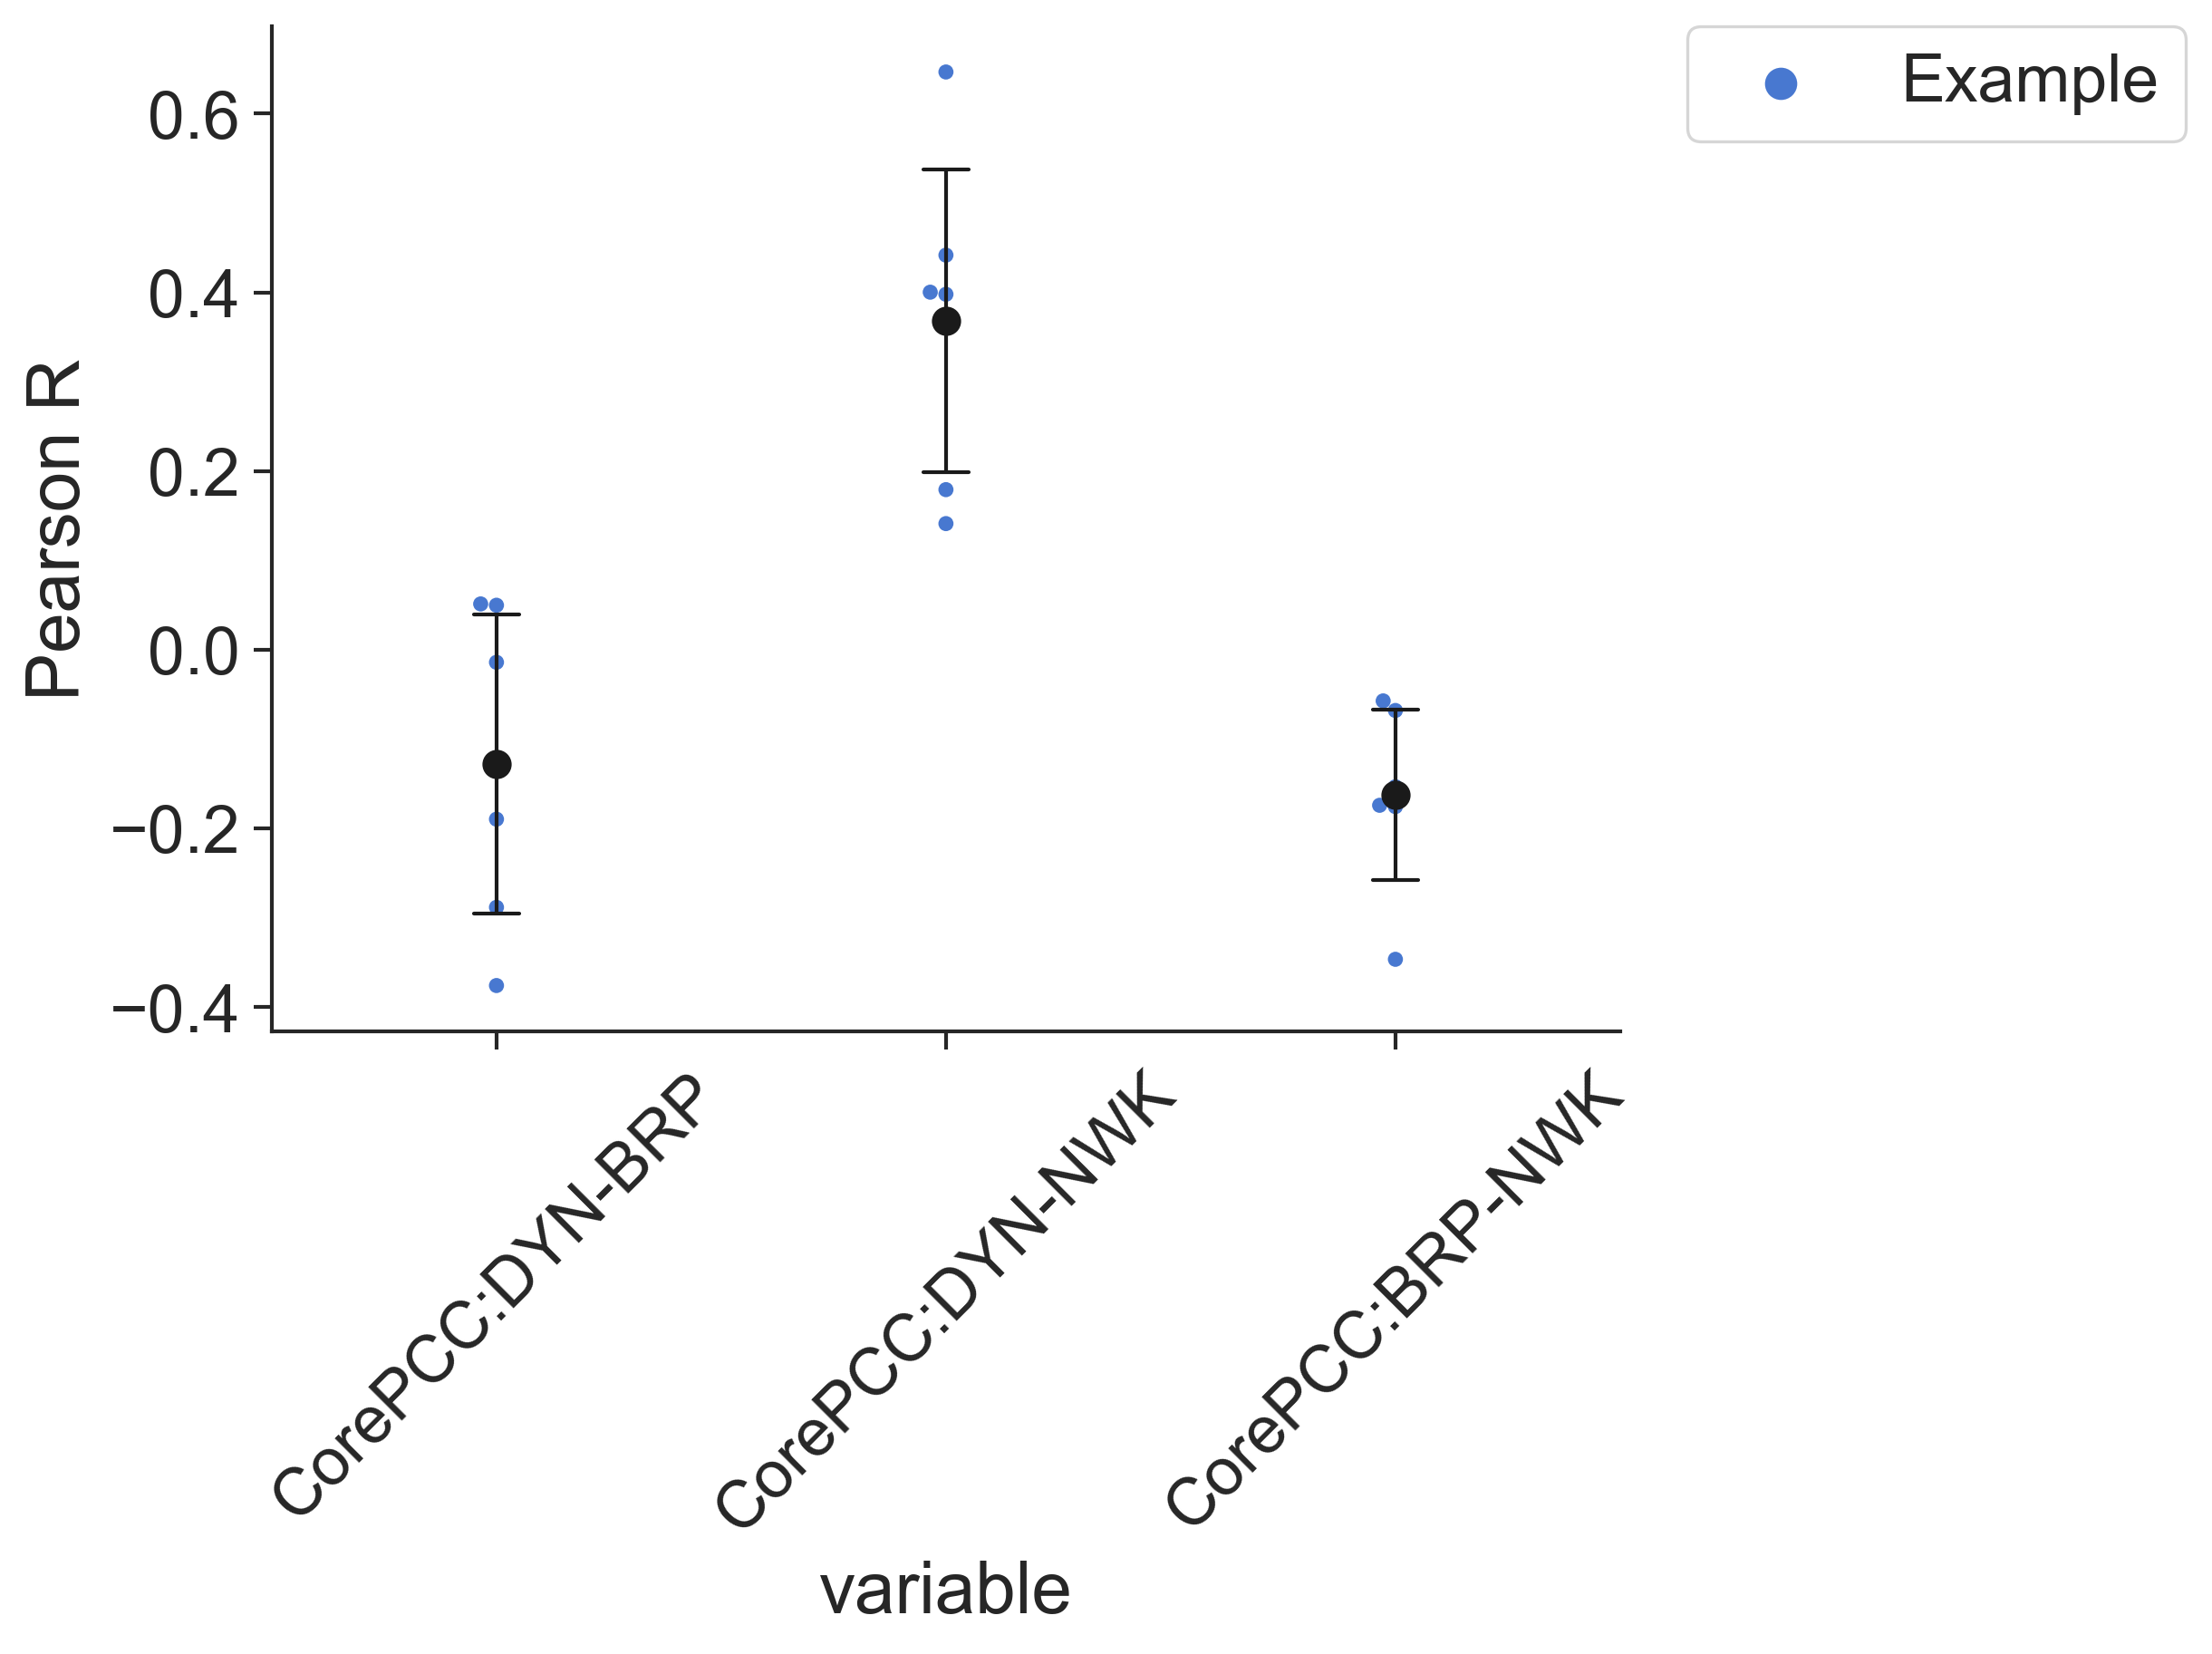

In [61]:
FIG = "CorePCC"

# Plot
sp = sns.swarmplot(data=PCCs, x="variable", y="Pearson R", order=Corepcc_order,
                   size=4, hue="Experiment", dodge=True, zorder=0)

sns.pointplot(data=PCCs, x="variable", y="Pearson R", order=Corepcc_order,
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, hue="Experiment", dodge=0.55, ax=sp)

# Tweak formatting and save plot
plt.xticks(rotation=45)
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(savepath, FIG+".svg"))
None

# Mesh Ratio

**Generate graph of raw values**

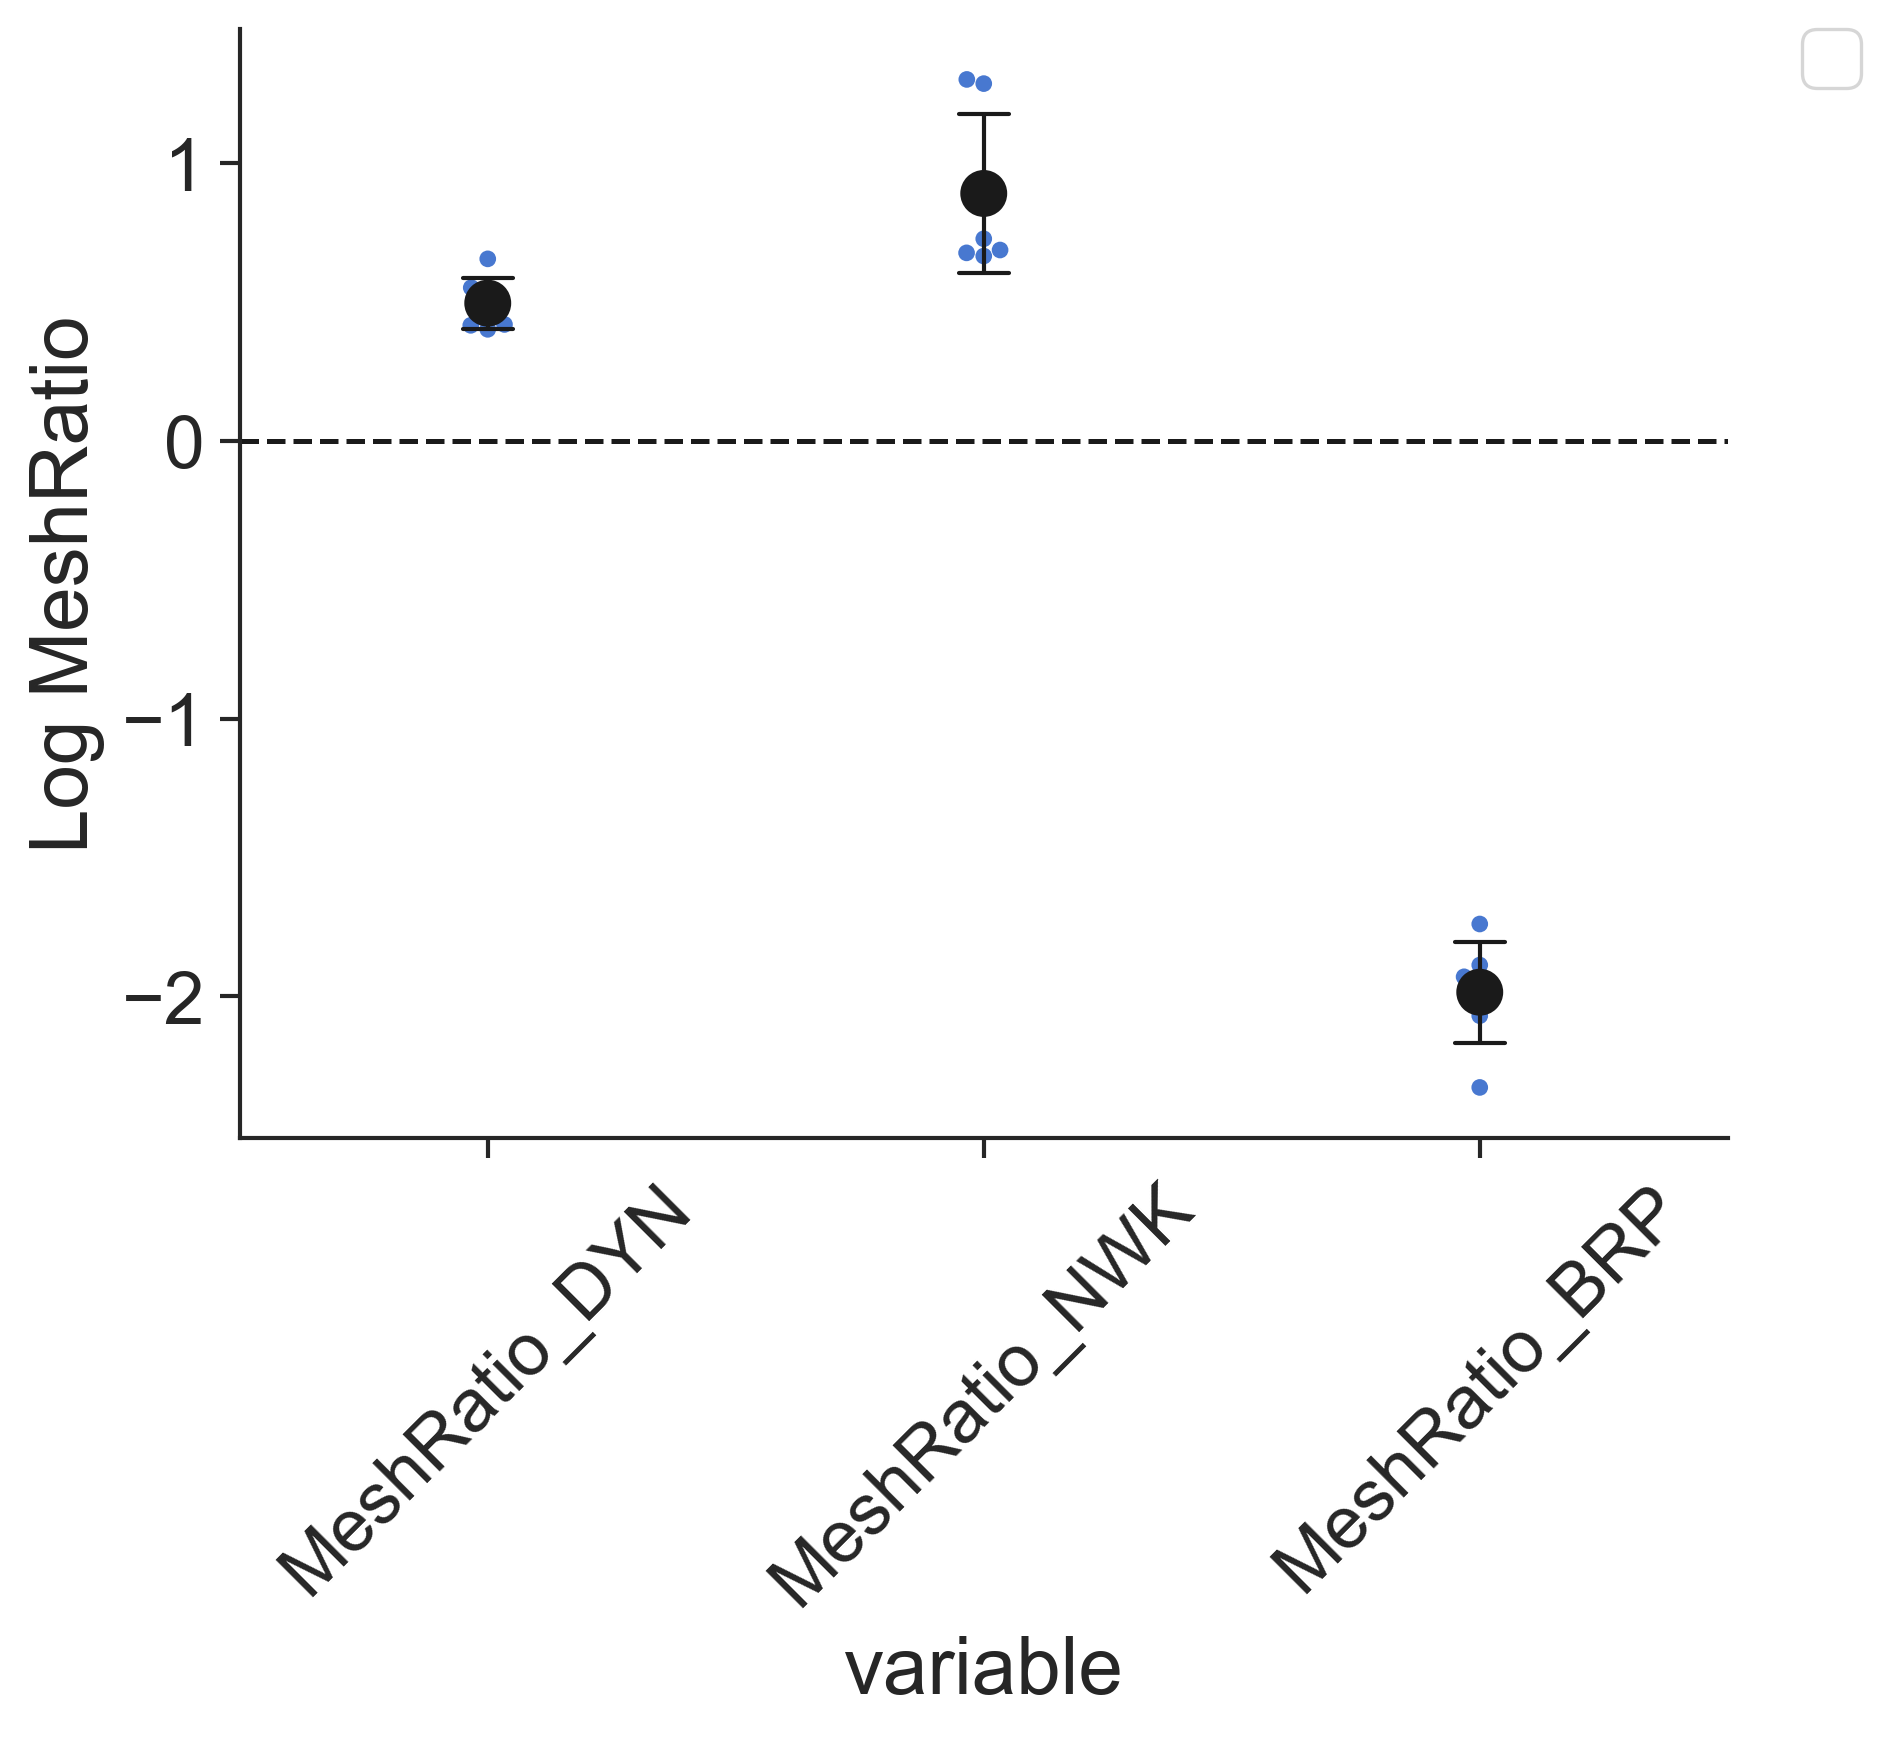

In [89]:
FIG = "MeshRatio"
ratio_order = CompMeshF_AZ.columns[CompMeshF_AZ.columns.str.contains("Ratio")]
#compRatio = agg.subset_data(CompMeshF_AZ, "Ratio")

# Calculate log2 of all ratios
LogRatio = np.log2(CompMeshF_AZ.loc[:, ratio_order])
#LogRatio = np.log2(compRatio.loc[:, ["Ratio" in x for x in compRatio.columns]])
LogRatio[["Experiment", "nmjid"]]=CompMeshF_AZ.loc[:, ["Experiment", "nmjid"]]

# Calculate nmjid and Experiment level means for superplot
ImgMean = LogRatio.groupby(["Experiment", "nmjid"]).mean().reset_index()


# Melt for plotting
ImgMean=ImgMean.melt(id_vars=["Experiment", "nmjid"], value_name="Log MeshRatio")

# Make an ordering vector specific to the MeshRatio columns
ratio_order = ["MeshRatio_"+c for c in data_order] + ["MeshRatio_BRP"]

# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="Log MeshRatio", 
                size=4, hue="Experiment", dodge=True, order=ratio_order, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="Log MeshRatio", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=ratio_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="Log MeshRatio",
              ci='sd', palette=['k'], scale=1.6,
              join=False, capsize=.1, errwidth=1, order=ratio_order, dodge=.55, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
#sp.set_ylim(.4, 1.6)

# Draw horizontal dashed line at 0
ax1 = sp.axes
ax1.axhline(0, ls='--', color='k')

plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

## Fig 2E Spottiness

c:\Users\rodallab\miniconda3\envs\paz-analysis\lib\site-packages\seaborn\categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


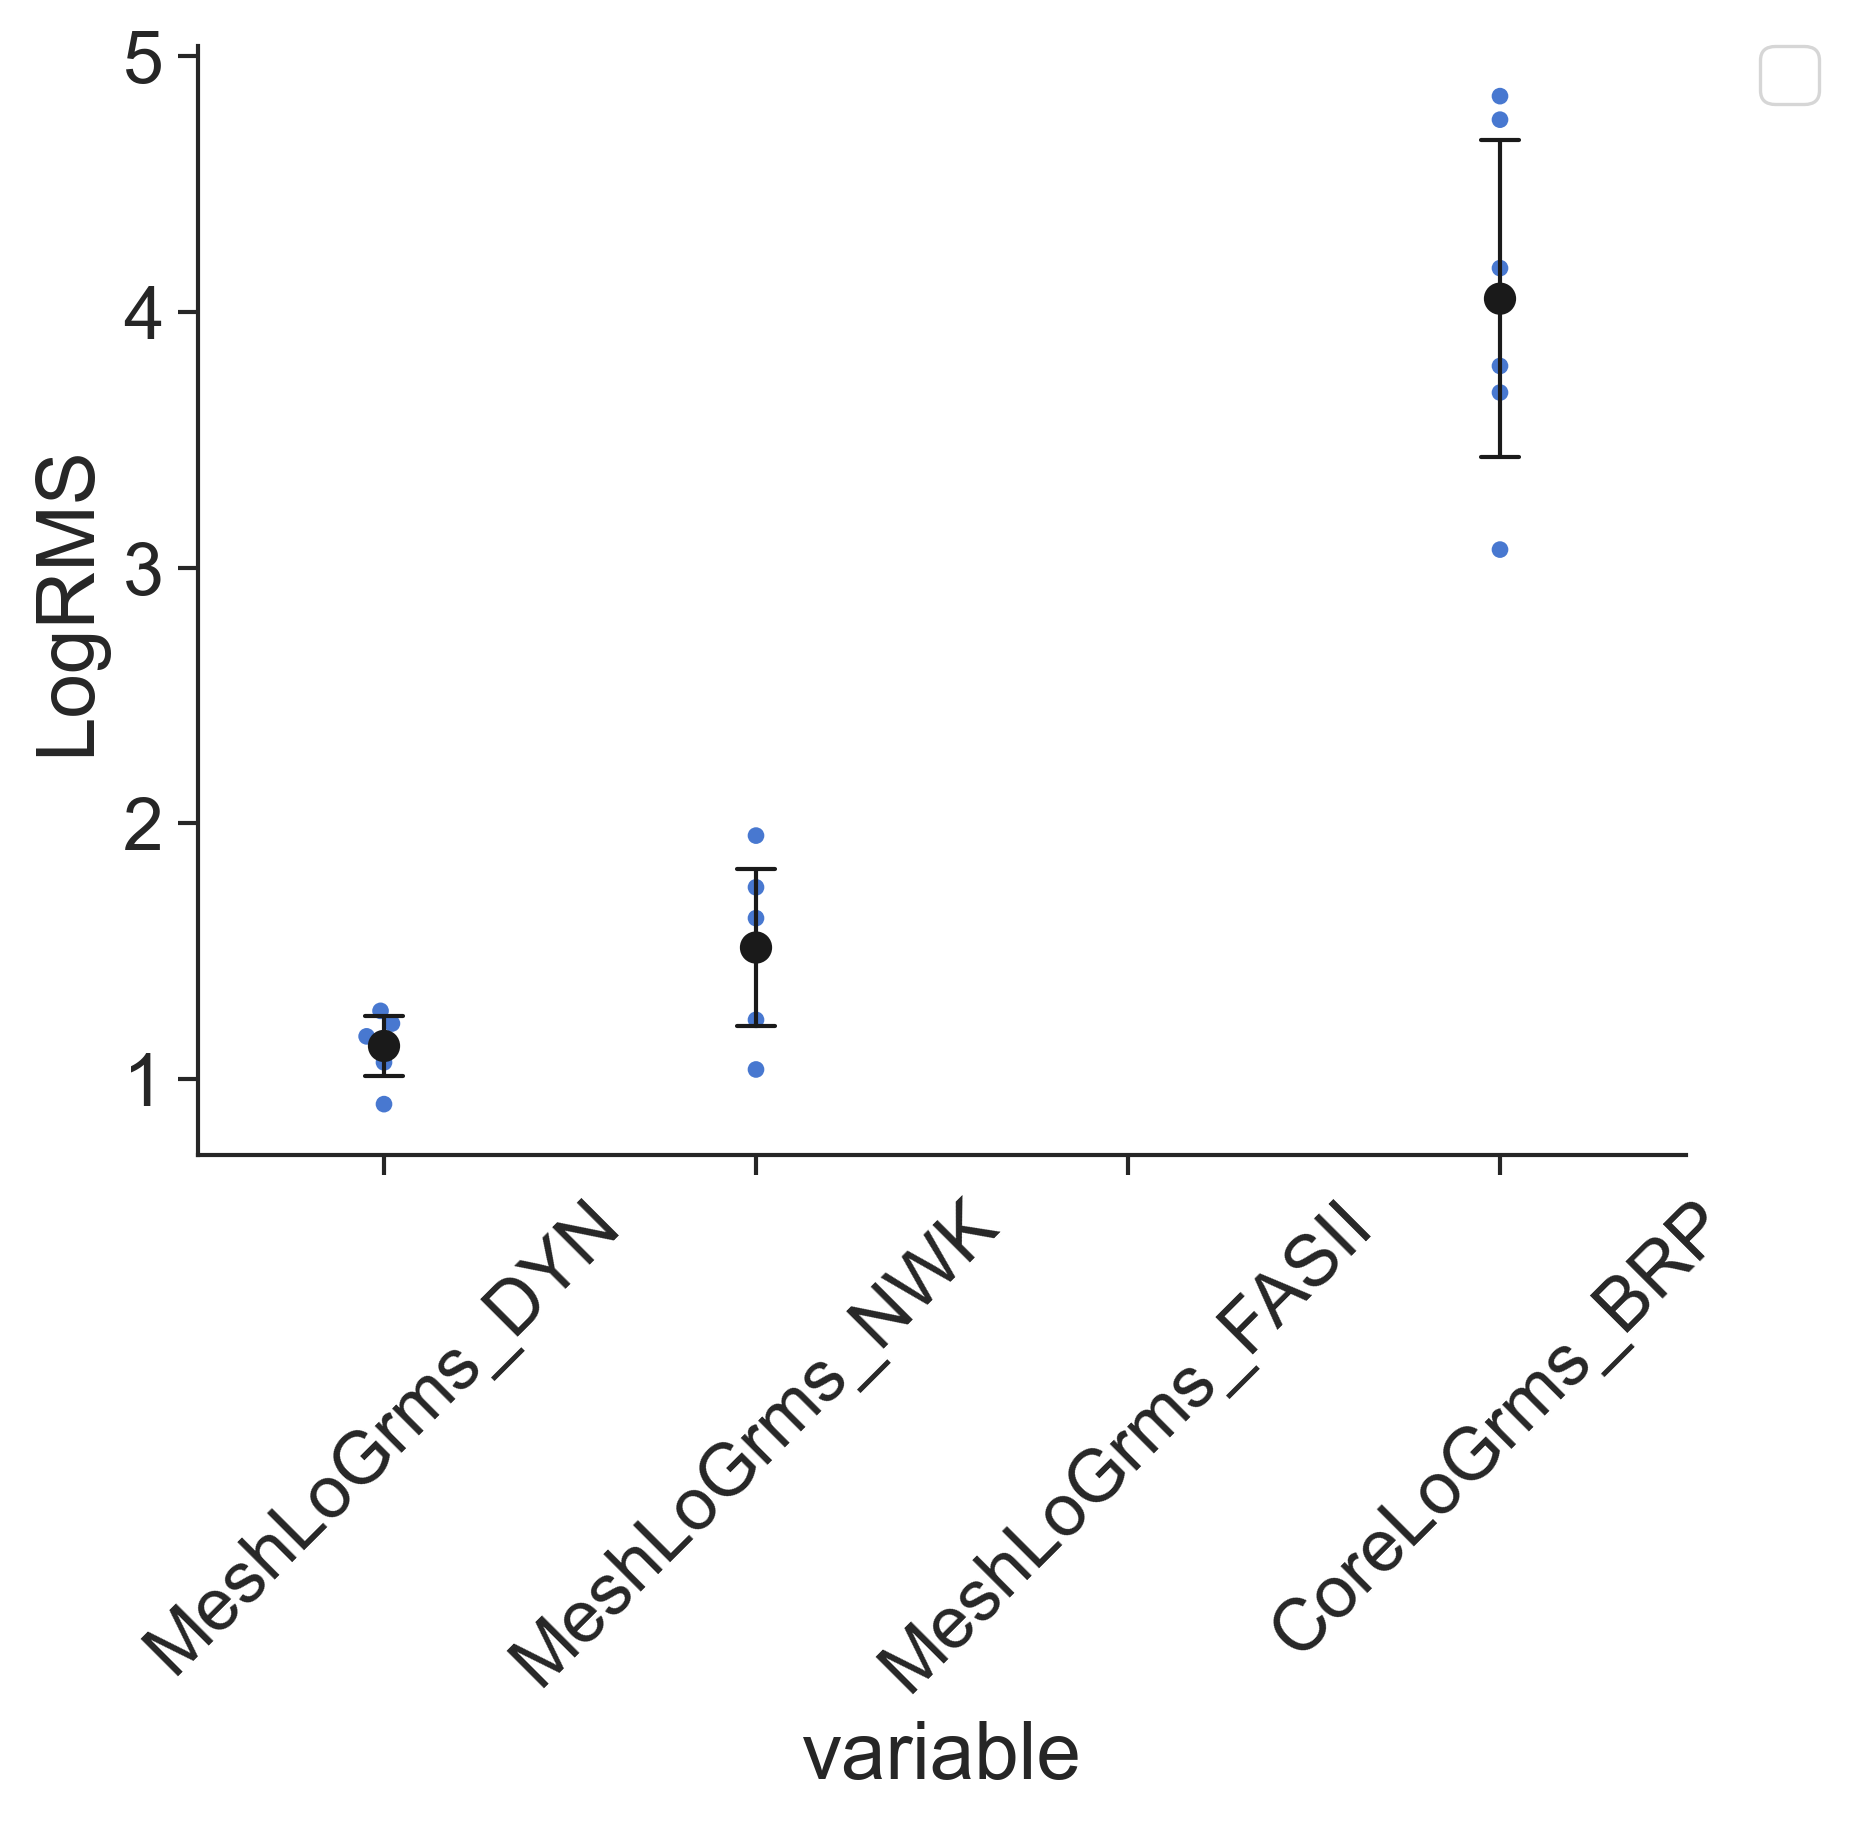

In [80]:
FIG = 'Spottiness'

# Make order vector for spottiness columns
spot_order = np.array([[f"CoreLoGrms_{chan}", f"MeshLoGrms_{chan}"] for chan in data_order]).flatten()

# Calculate nmjid and Experiment level means for superplot
ImgMean = CompMeshF_AZ.groupby(["Experiment", "nmjid"]).mean().reset_index()

# Melt for plotting
ImgMean=ImgMean.melt(id_vars=["Experiment", "nmjid"], value_name="LogRMS")

# Make an ordering vector specific to the MeshRatio columns
spot_order = [f"MeshLoGrms_{c}" for c in data_order] + ["CoreLoGrms_BRP"]

# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="LogRMS", hue="Experiment", dodge=True, size=4, order=spot_order, zorder=0)

sns.pointplot(data=ImgMean, x="variable", y="LogRMS",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, order=spot_order,dodge=0.55, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [83]:
ImgMean

,Experiment,nmjid,variable,LogRMS
0,Example,SD555_5mm_L1_m4_2020_12_06__09_42_45_,AZcount,1.166667
1,Example,SD555_5mm_L2__2020_12_06__10_15_39_,AZcount,1.000000
2,Example,SD555_5mm_L3__2020_12_06__10_42_15_,AZcount,1.150000
3,Example,SD555_5mm_L3__2020_12_06__10_55_22_,AZcount,1.000000
4,Example,SD555_5mm_L4__2020_12_06__13_28_14_,AZcount,1.000000
...,...,...,...,...
283,Example,SD555_5mm_L2__2020_12_06__10_15_39_,EntrD8_NWK,5.137289
284,Example,SD555_5mm_L3__2020_12_06__10_42_15_,EntrD8_NWK,4.851855
285,Example,SD555_5mm_L3__2020_12_06__10_55_22_,EntrD8_NWK,4.760600
286,Example,SD555_5mm_L4__2020_12_06__13_28_14_,EntrD8_NWK,5.033000


In [86]:
ImgMean = CompMeshF_AZ.groupby(["Experiment", "nmjid"]).mean().reset_index()
totest = ImgMean.loc[:, [f"MeshLoGrms_{c}" for c in data_order]]
analysis = agg.compareGroups(totest)
analysis['posthoc'].to_csv(os.path.join(statspath, FIG+"_Posthoc.csv"))

Performed Kruskal-Wallis: test statistic = 3.6923076923076934 p-value:0.054663935891675085


## Mesh Area and AZ area

In [88]:
sums=CompMesh.groupby(["Image", "geno"]).sum()
azdensity = pd.DataFrame({"density":sums.AZcount/sums.Area}).reset_index()
azdensity

,Image,geno,density
0,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,cont,4.245087
1,SD622_cont_L01_m4__2022_06_10__17_06_59-Airysc...,cont,4.575185
2,SD622_cont_L01_m4__2022_06_10__17_11_12-Airysc...,cont,3.612098
3,SD622_cont_L02_m4__2022_06_10__17_21_21-Airysc...,cont,3.889464
4,SD622_cont_L02_m4__2022_06_10__17_26_56-Airysc...,cont,2.878182
...,...,...,...
56,SD622_rab3_L04_m4_a3_2022_06_11__13_20_17-Airy...,rab3,1.221605
57,SD622_rab3_L04_m4_a4_2022_06_11__13_26_38-Airy...,rab3,1.498571
58,SD622_rab3_L05_m4_a3_2022_06_11__13_31_41-Airy...,rab3,2.254046
59,SD622_rab3_L05_m4_a3_2022_06_11__13_41_52-Airy...,rab3,2.006586


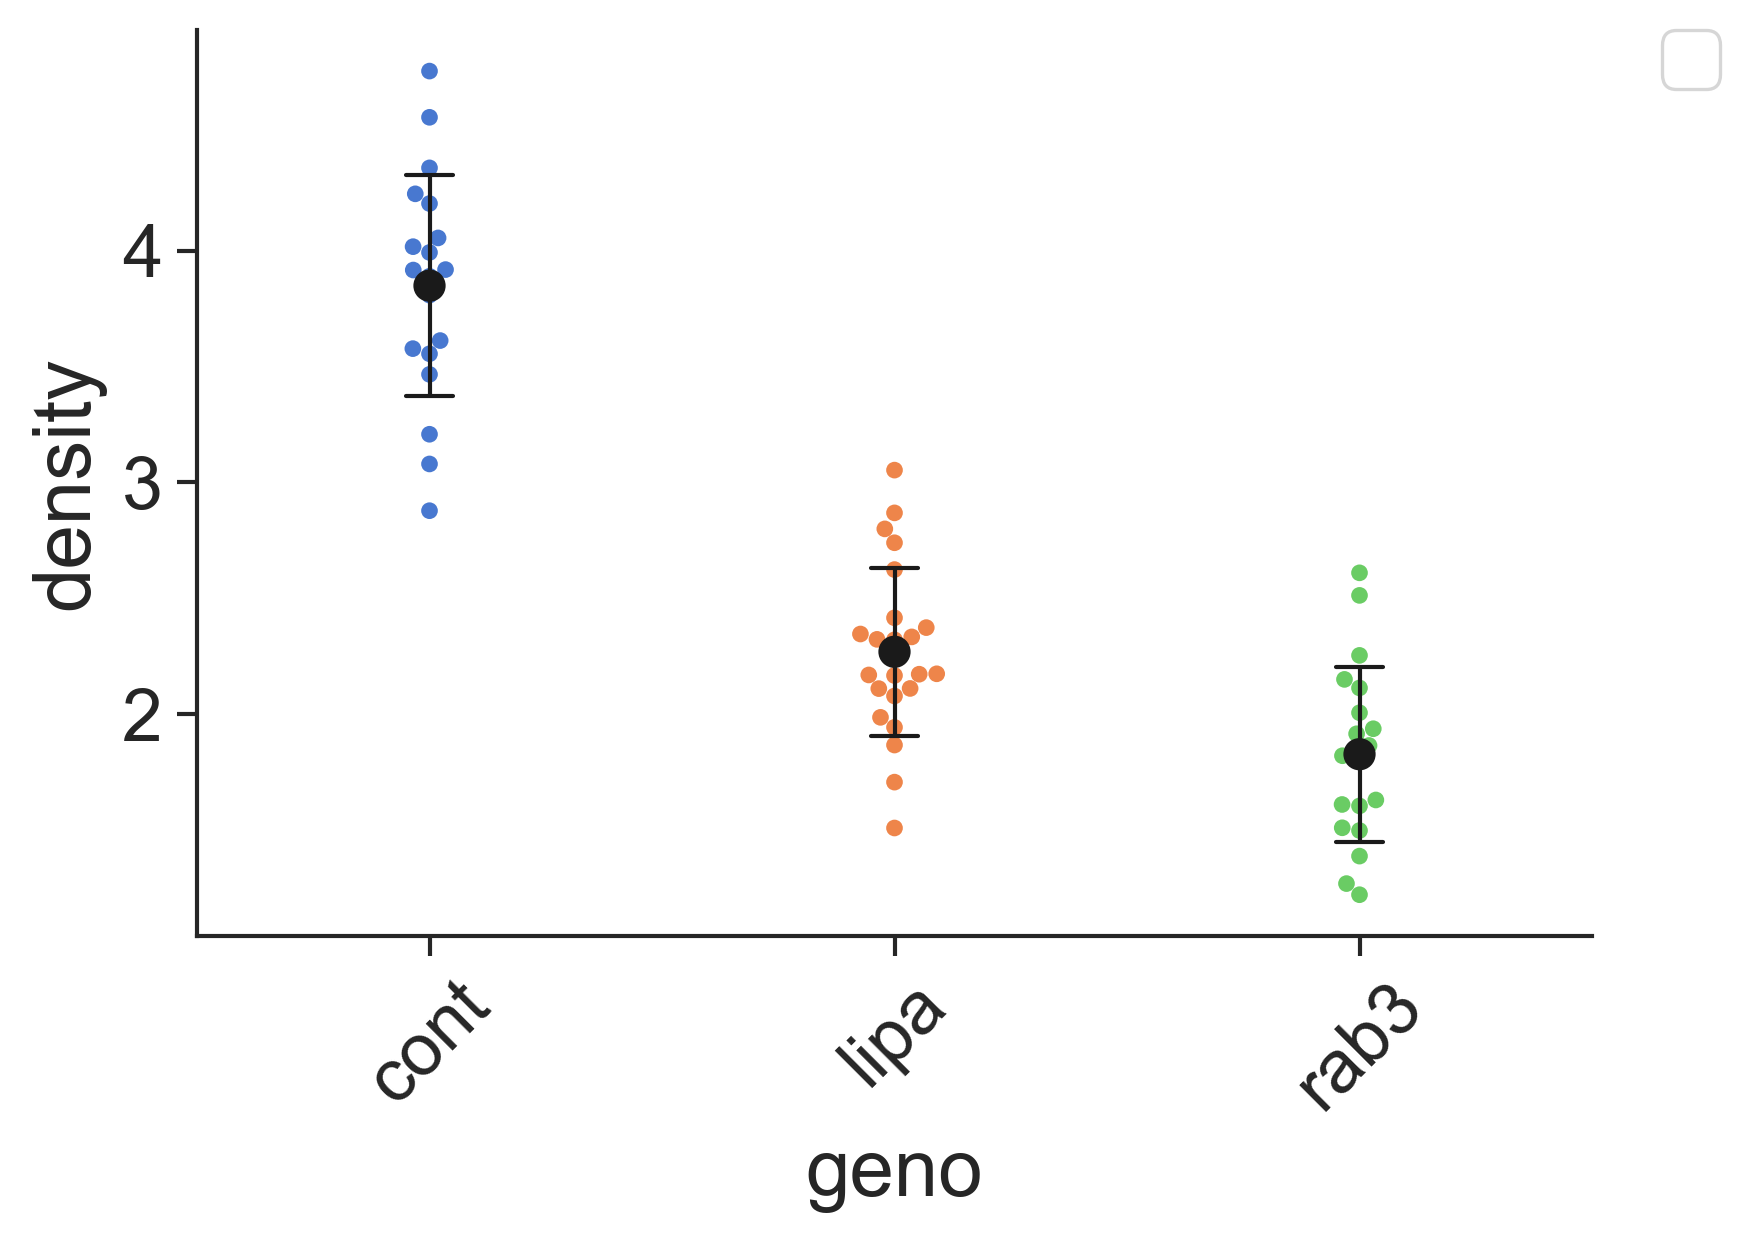

In [93]:
# Plot
sp = sns.swarmplot(data=azdensity, x="geno", y="density", size=4, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=azdensity, x="geno", y="density",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
None
plt.savefig(os.path.join(savepath, "SD622_AZdensity.svg"))

In [98]:
ImgMean=CompMesh.groupby(["Image", "geno"]).mean().reset_index()
ImgMean.melt(id_vars=["Image", "geno"])

,Image,geno,variable,value
0,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,cont,AZcount,0.979592
1,SD622_cont_L01_m4__2022_06_10__17_06_59-Airysc...,cont,AZcount,1.187500
2,SD622_cont_L01_m4__2022_06_10__17_11_12-Airysc...,cont,AZcount,0.992647
3,SD622_cont_L02_m4__2022_06_10__17_21_21-Airysc...,cont,AZcount,0.931034
4,SD622_cont_L02_m4__2022_06_10__17_26_56-Airysc...,cont,AZcount,0.754098
...,...,...,...,...
2923,SD622_rab3_L04_m4_a3_2022_06_11__13_20_17-Airy...,rab3,EntrD8_BRP,4.866067
2924,SD622_rab3_L04_m4_a4_2022_06_11__13_26_38-Airy...,rab3,EntrD8_BRP,5.203390
2925,SD622_rab3_L05_m4_a3_2022_06_11__13_31_41-Airy...,rab3,EntrD8_BRP,5.291788
2926,SD622_rab3_L05_m4_a3_2022_06_11__13_41_52-Airy...,rab3,EntrD8_BRP,5.110708


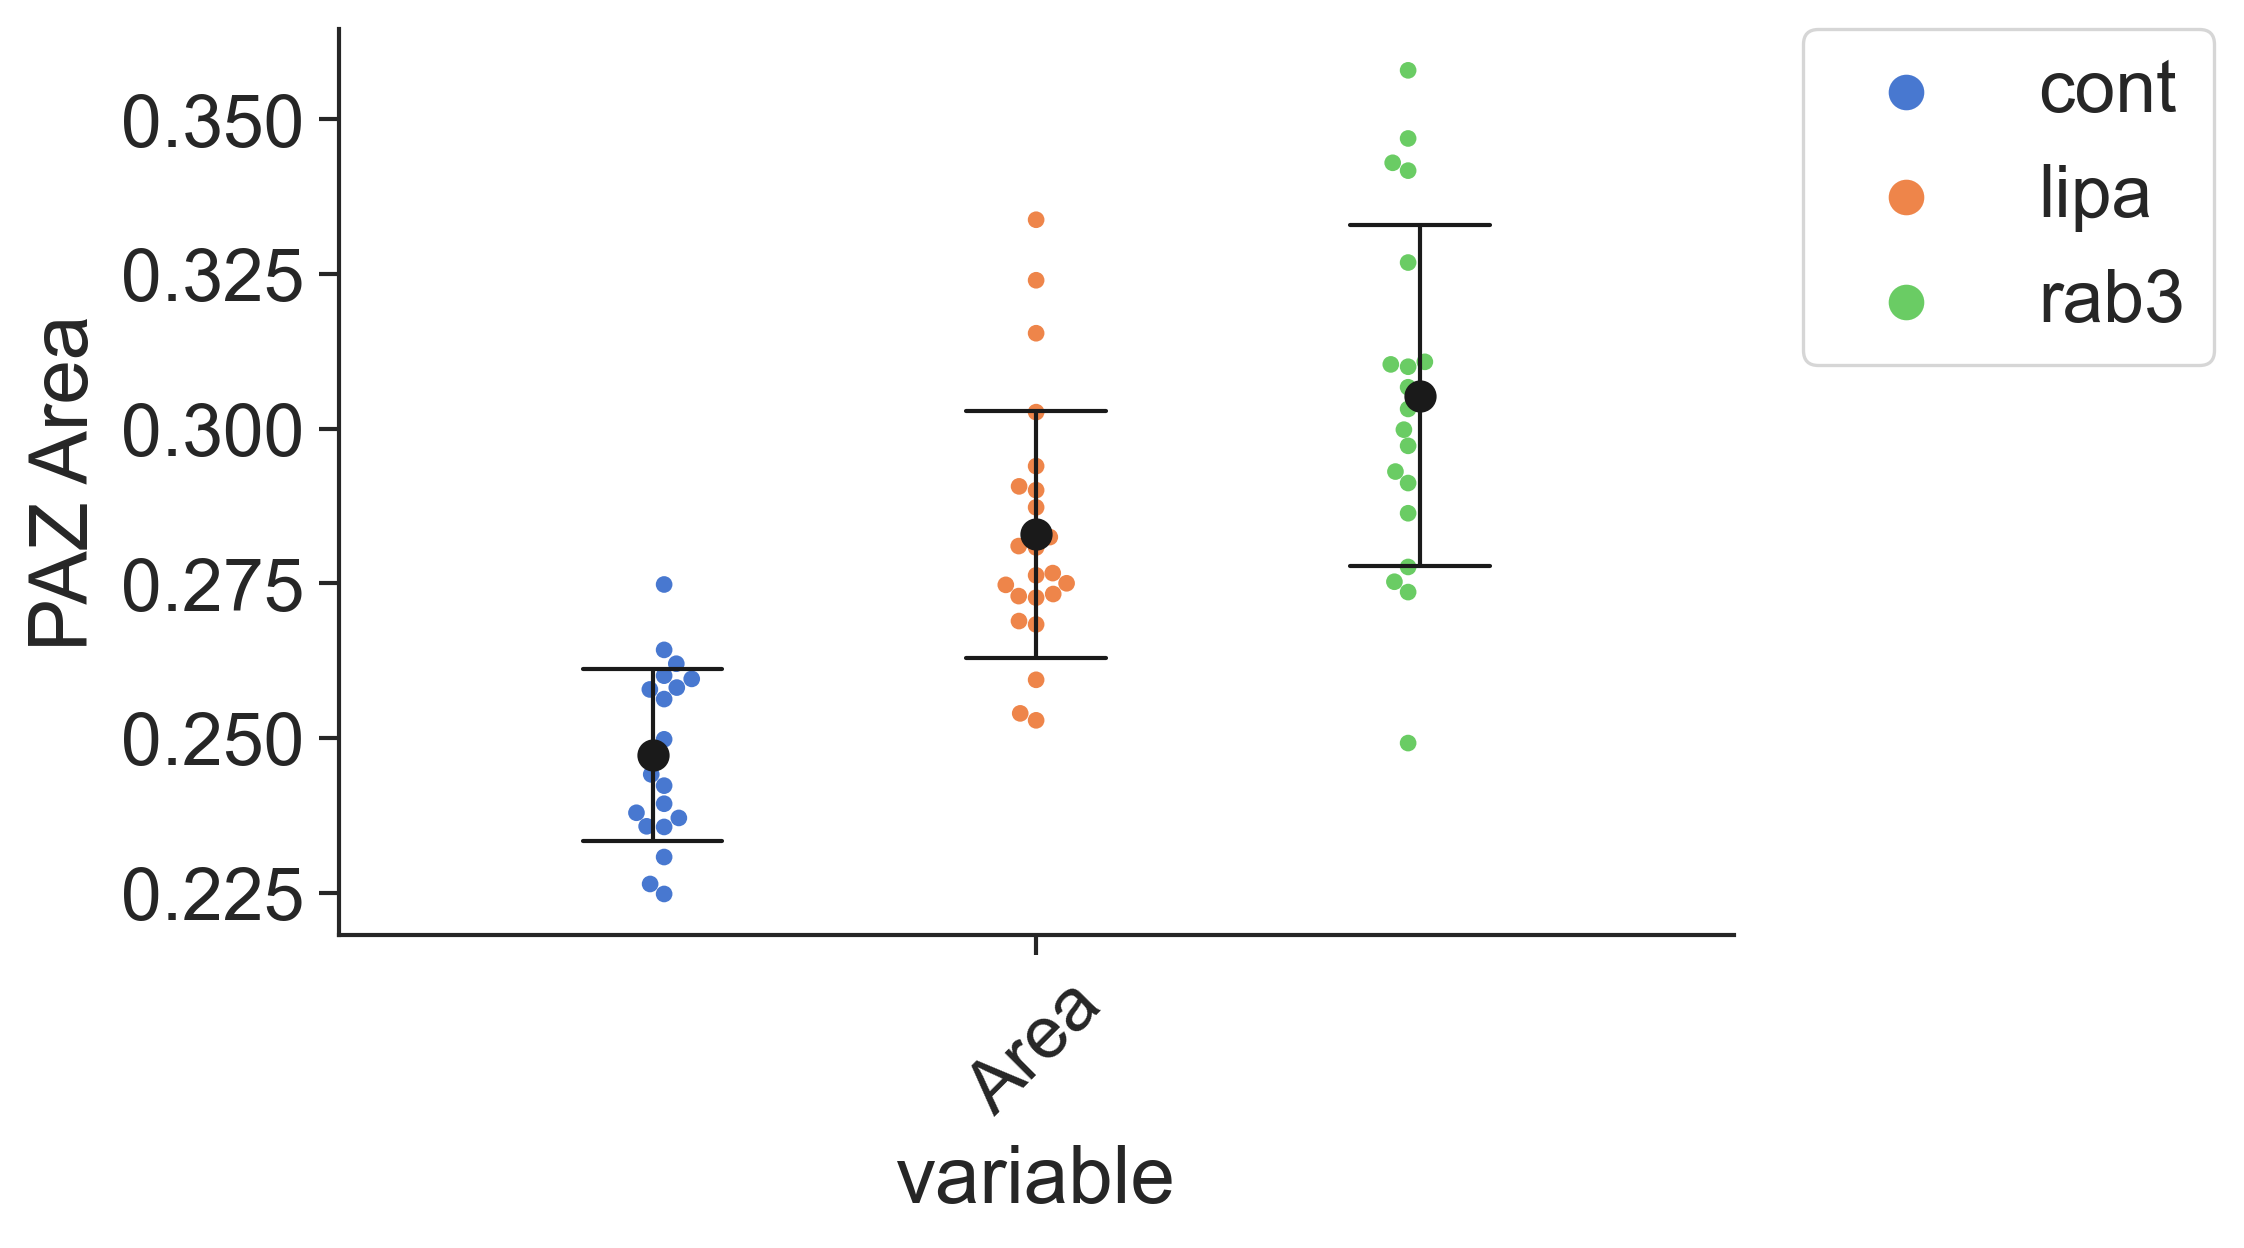

In [105]:
ImgMean=CompMesh.groupby(["Image", "geno"]).mean().reset_index().melt(id_vars=["geno", "Image"])
sp = sns.swarmplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=True, size=4, order=["Area"], zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=0.55, 
              order=["Area"], ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
sp.set_ylabel("PAZ Area")
None
plt.savefig(os.path.join(savepath, "SD622_CompArea.svg"))

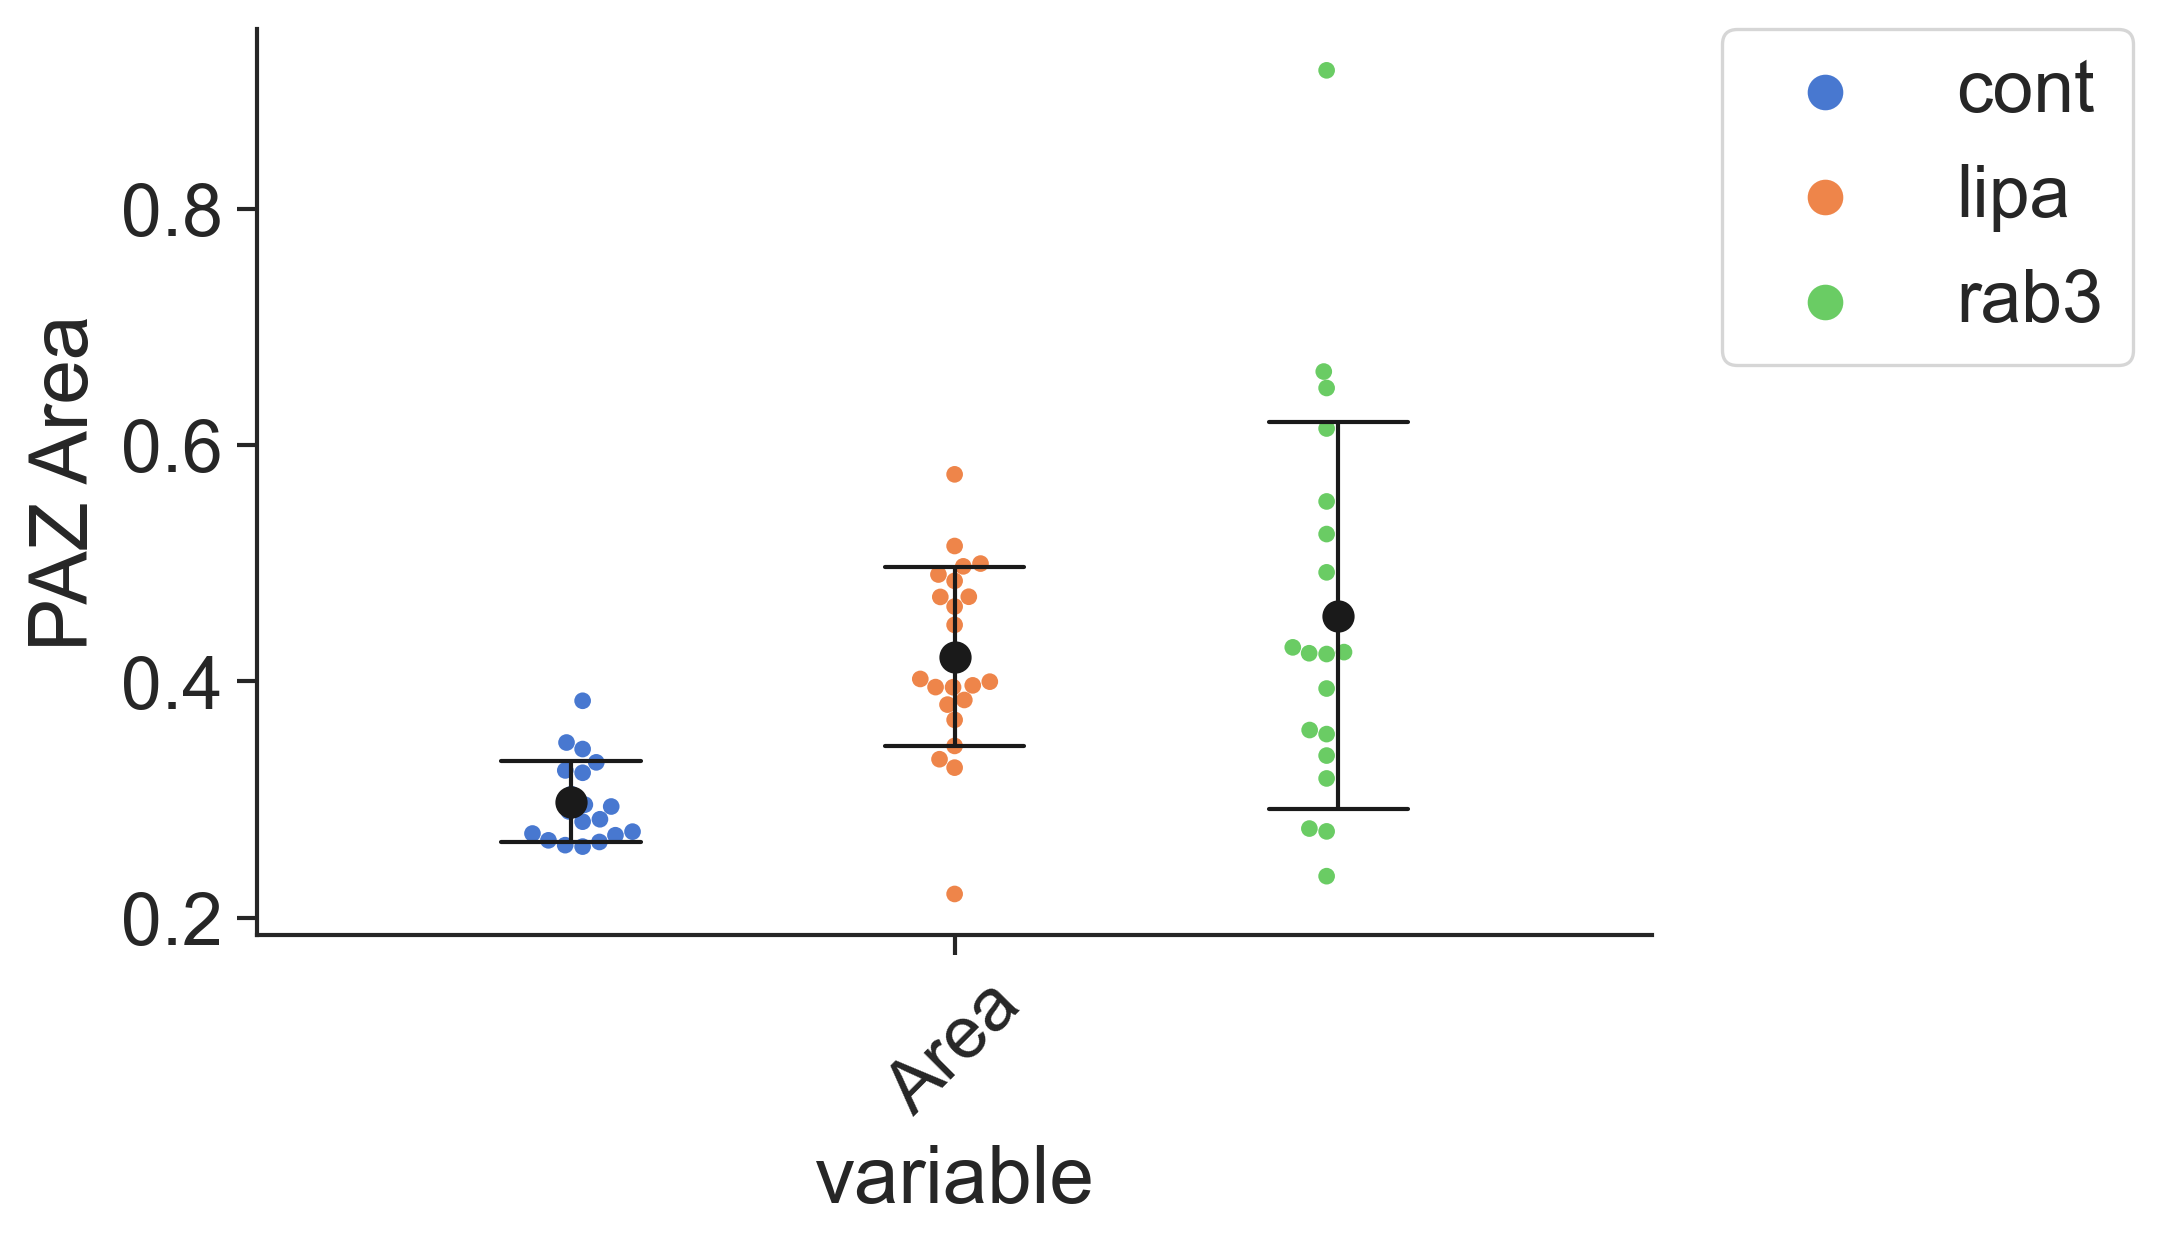

In [104]:
ImgMean=CompMeshF_AZ.groupby(["Image", "geno"]).mean().reset_index().melt(id_vars=["geno", "Image"])
sp = sns.swarmplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=True, size=4, order=["Area"], zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=0.55, 
              order=["Area"], ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
sp.set_ylabel("PAZ Area")
None
plt.savefig(os.path.join(savepath, "SD622_CompF-AZ_Area.svg"))

## Fig 4B Intensity correlations/heatmap to AZ integrated density

**For additional code and analysis, see SD601h**

In [162]:
PCC_matrix = Composite_1AZ.groupby("geno").corr()
# Pivot to a nice table
PCCazid = PCC_matrix.AZidtotal #.reset_index(level=0)

PCCazid=PCCazid.unstack("geno")
PCCazid.index=PCCazid.index.str.split("_", expand=True)

#table=PCCazid.unstack().loc[Intensity_cols].drop(np.nan, axis=1, level=1)

#table

geno            cont                          lipa                      \
                 BRP       DYN       NWK       BRP       DYN       NWK   
CoreMean    0.651253  0.181521  0.075596  0.660848  0.193245  0.120753   
CoreCoV    -0.105987  0.027434  0.021797 -0.045977  0.054221  0.077980   
CoreLoGrms  0.300512  0.204211  0.094211  0.391332  0.197988  0.126025   
MeshMean    0.283132  0.316404  0.264166  0.315661  0.213553  0.250031   
MeshCoV     0.136807  0.085231  0.061399  0.269607  0.095431  0.020833   
MeshLoGrms  0.182651  0.280525  0.208658  0.283153  0.157127  0.125822   
MeshRatio  -0.236311 -0.032641  0.056955 -0.330365 -0.052889 -0.008432   

geno            rab3                      
                 BRP       DYN       NWK  
CoreMean    0.634583  0.244395  0.163565  
CoreCoV    -0.002735  0.043094  0.092665  
CoreLoGrms  0.402531  0.269558  0.162074  
MeshMean    0.343939  0.187239  0.198423  
MeshCoV     0.418145  0.222257  0.177853  
MeshLoGrms  0.309068  0.178451  0.178523  
MeshRatio  -0.215825 -0.144953 -0.100462

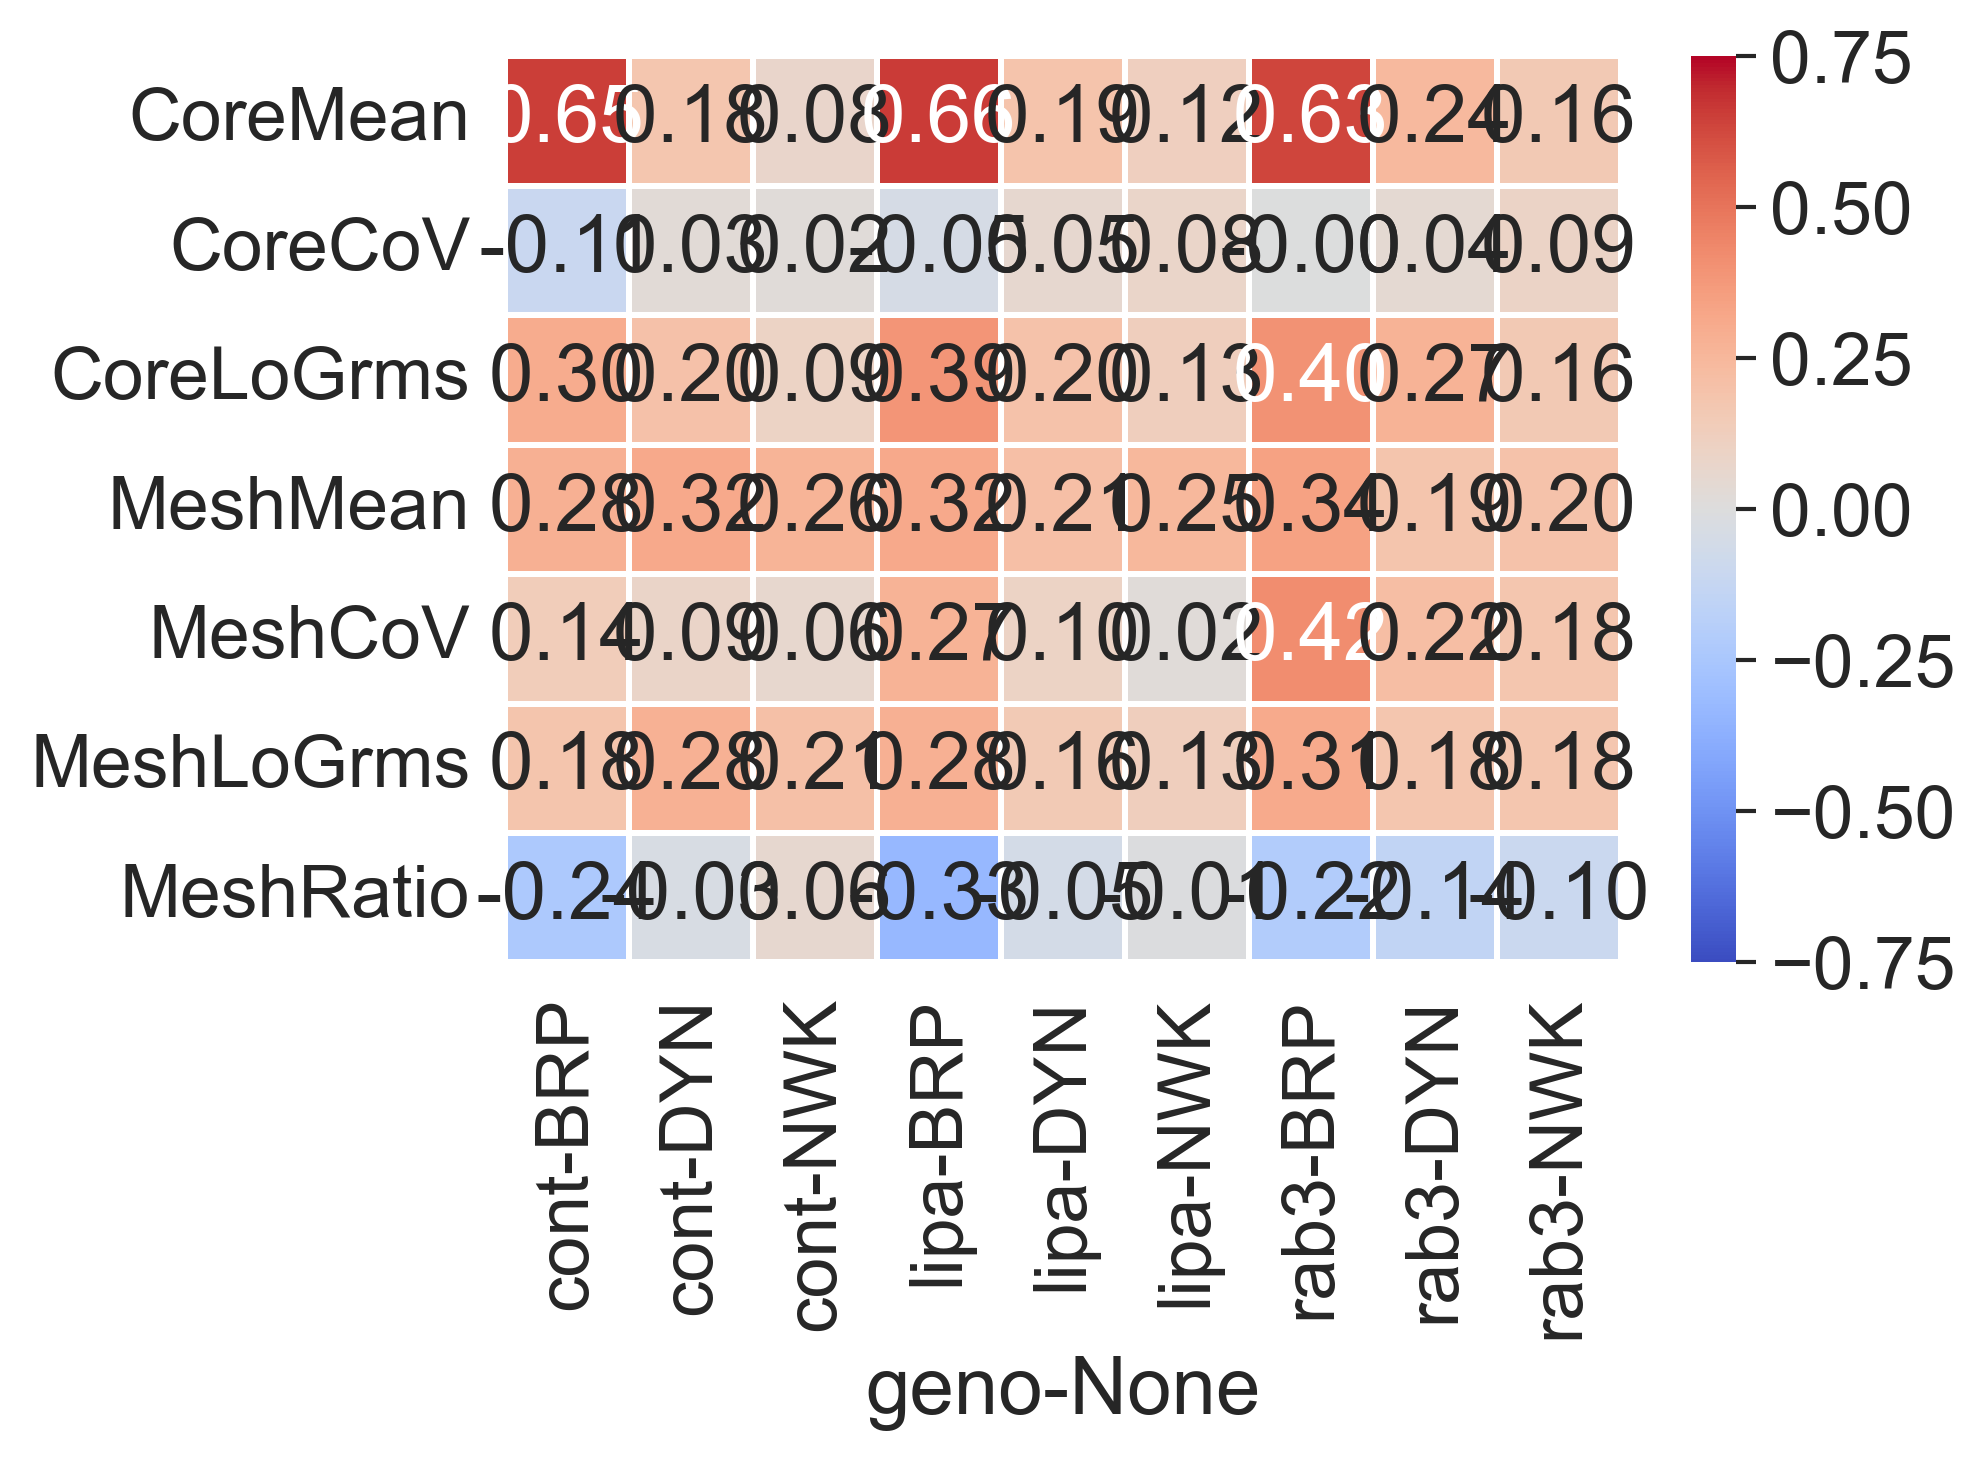

In [167]:
FIG = "SD622_AZ-PAZmatrix"
# Define columns to analyze for this panel:
Intensity_cols = ["CoreMean", "CoreCoV", "CoreLoGrms", "MeshMean", "MeshCoV", "MeshLoGrms", "MeshRatio"]

# Calculate Correlation matrix for single AZ containing meshes
PCC_matrix = Composite_1AZ.groupby("geno").corr()
# Pivot to a nice table
PCCazid = PCC_matrix.AZidtotal #.reset_index(level=0)

PCCazid=PCCazid.unstack("geno")
PCCazid.index=PCCazid.index.str.split("_", expand=True)

table=PCCazid.unstack().loc[Intensity_cols].drop(np.nan, axis=1, level=1)
table2=table
# Reorder columns to match other graphs
#table2 = table.reindex(["NWK", "DYN", "BRP"], level=1)

# Make heatmap
hm = sns.heatmap(data=table2, cmap='coolwarm', vmin=-.75, vmax=.75,
                 linewidth=1, center=0, annot=True, fmt='1.2f')
hm.tick_params(bottom=False, left=False)
plt.savefig(os.path.join(savepath, FIG + ".svg"))

In [37]:
PCCazid.to_csv(os.path.join(savepath, "TableS1.csv"))

## Fig 4C-D high vs low AZid meshes

## Fig 4D mean mesh in high-lo

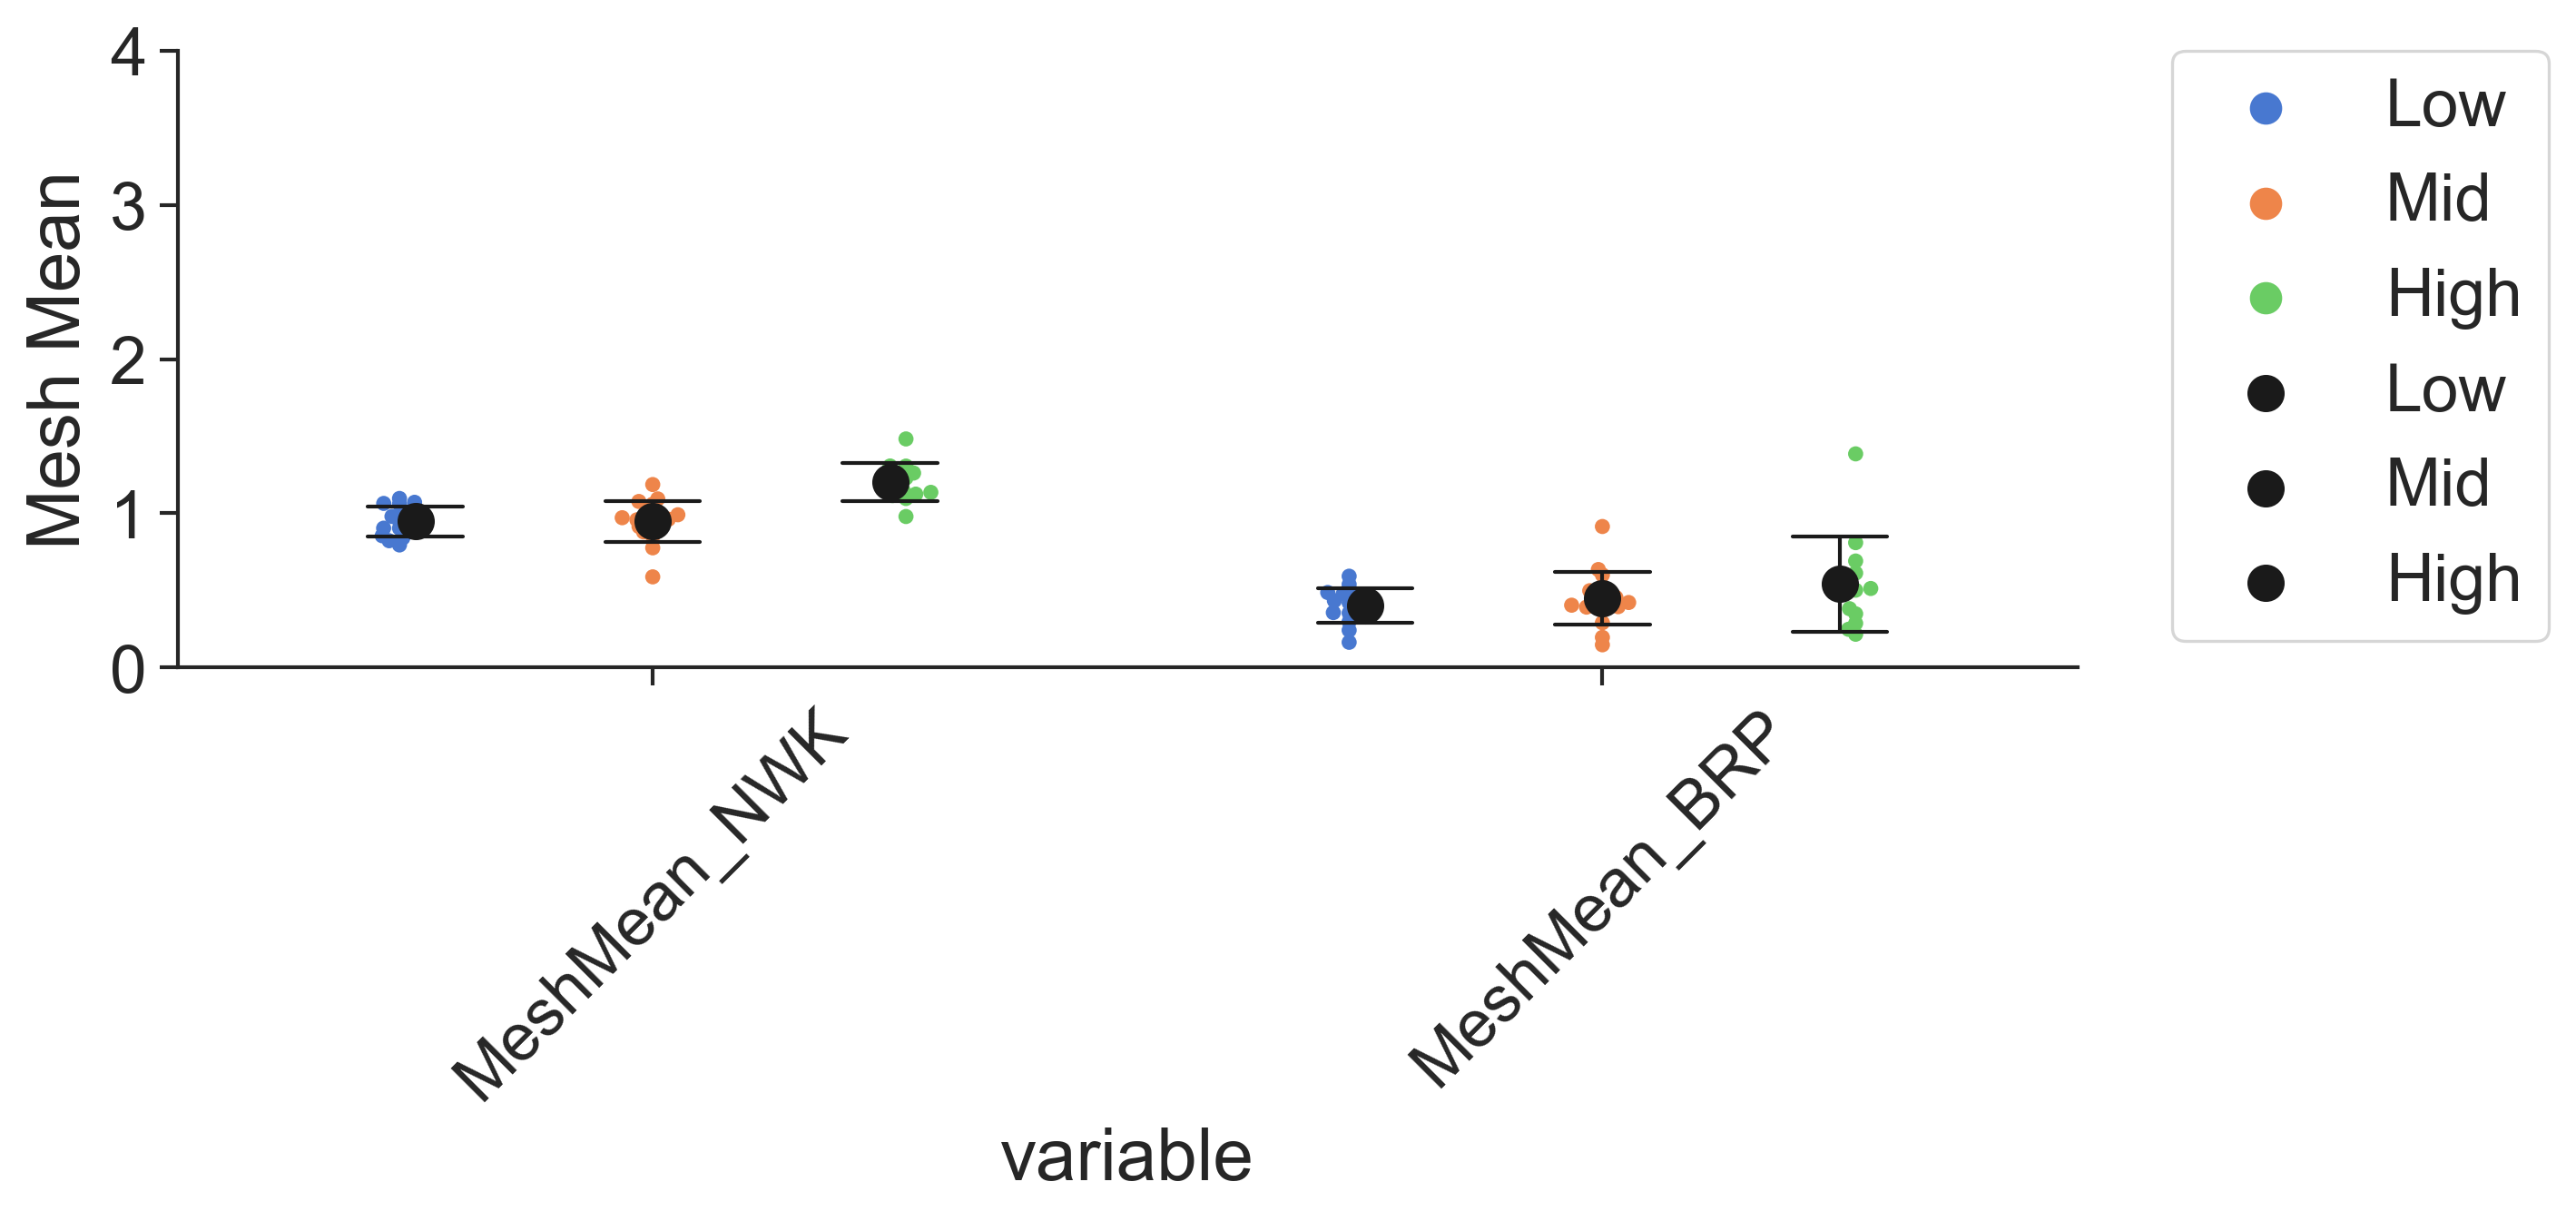

In [39]:
FIG = "Fig 4D_MeshMeanBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))
# Create a copy of the 1AZ filtered dataset and bin by AZ-id quantile
az1copy = Composite_1AZ.copy()
azid = az1copy.AZidtotal
az1copy["bins"]="Mid"
az1copy.bins.where(azid>azid.quantile(.25), "Low", inplace=True)
az1copy.bins.where(azid<azid.quantile(.75), "High", inplace=True)

# Subset Mesh Mean data
cols = ["Experiment", "nmjid", "bins"] + [f"MeshMean_{chan}" for chan in data_order] + ["MeshMean_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Mesh Mean")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Mesh Mean")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Mesh Mean", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Mesh Mean",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [40]:
# Stats for mesh mean
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 1.2568422717924363 p-value:0.5334333552585555
Performed Kruskal-Wallis: test statistic = 20.38063597532036 p-value:3.753195000276628e-05


## Fig 4C Core Mean binned

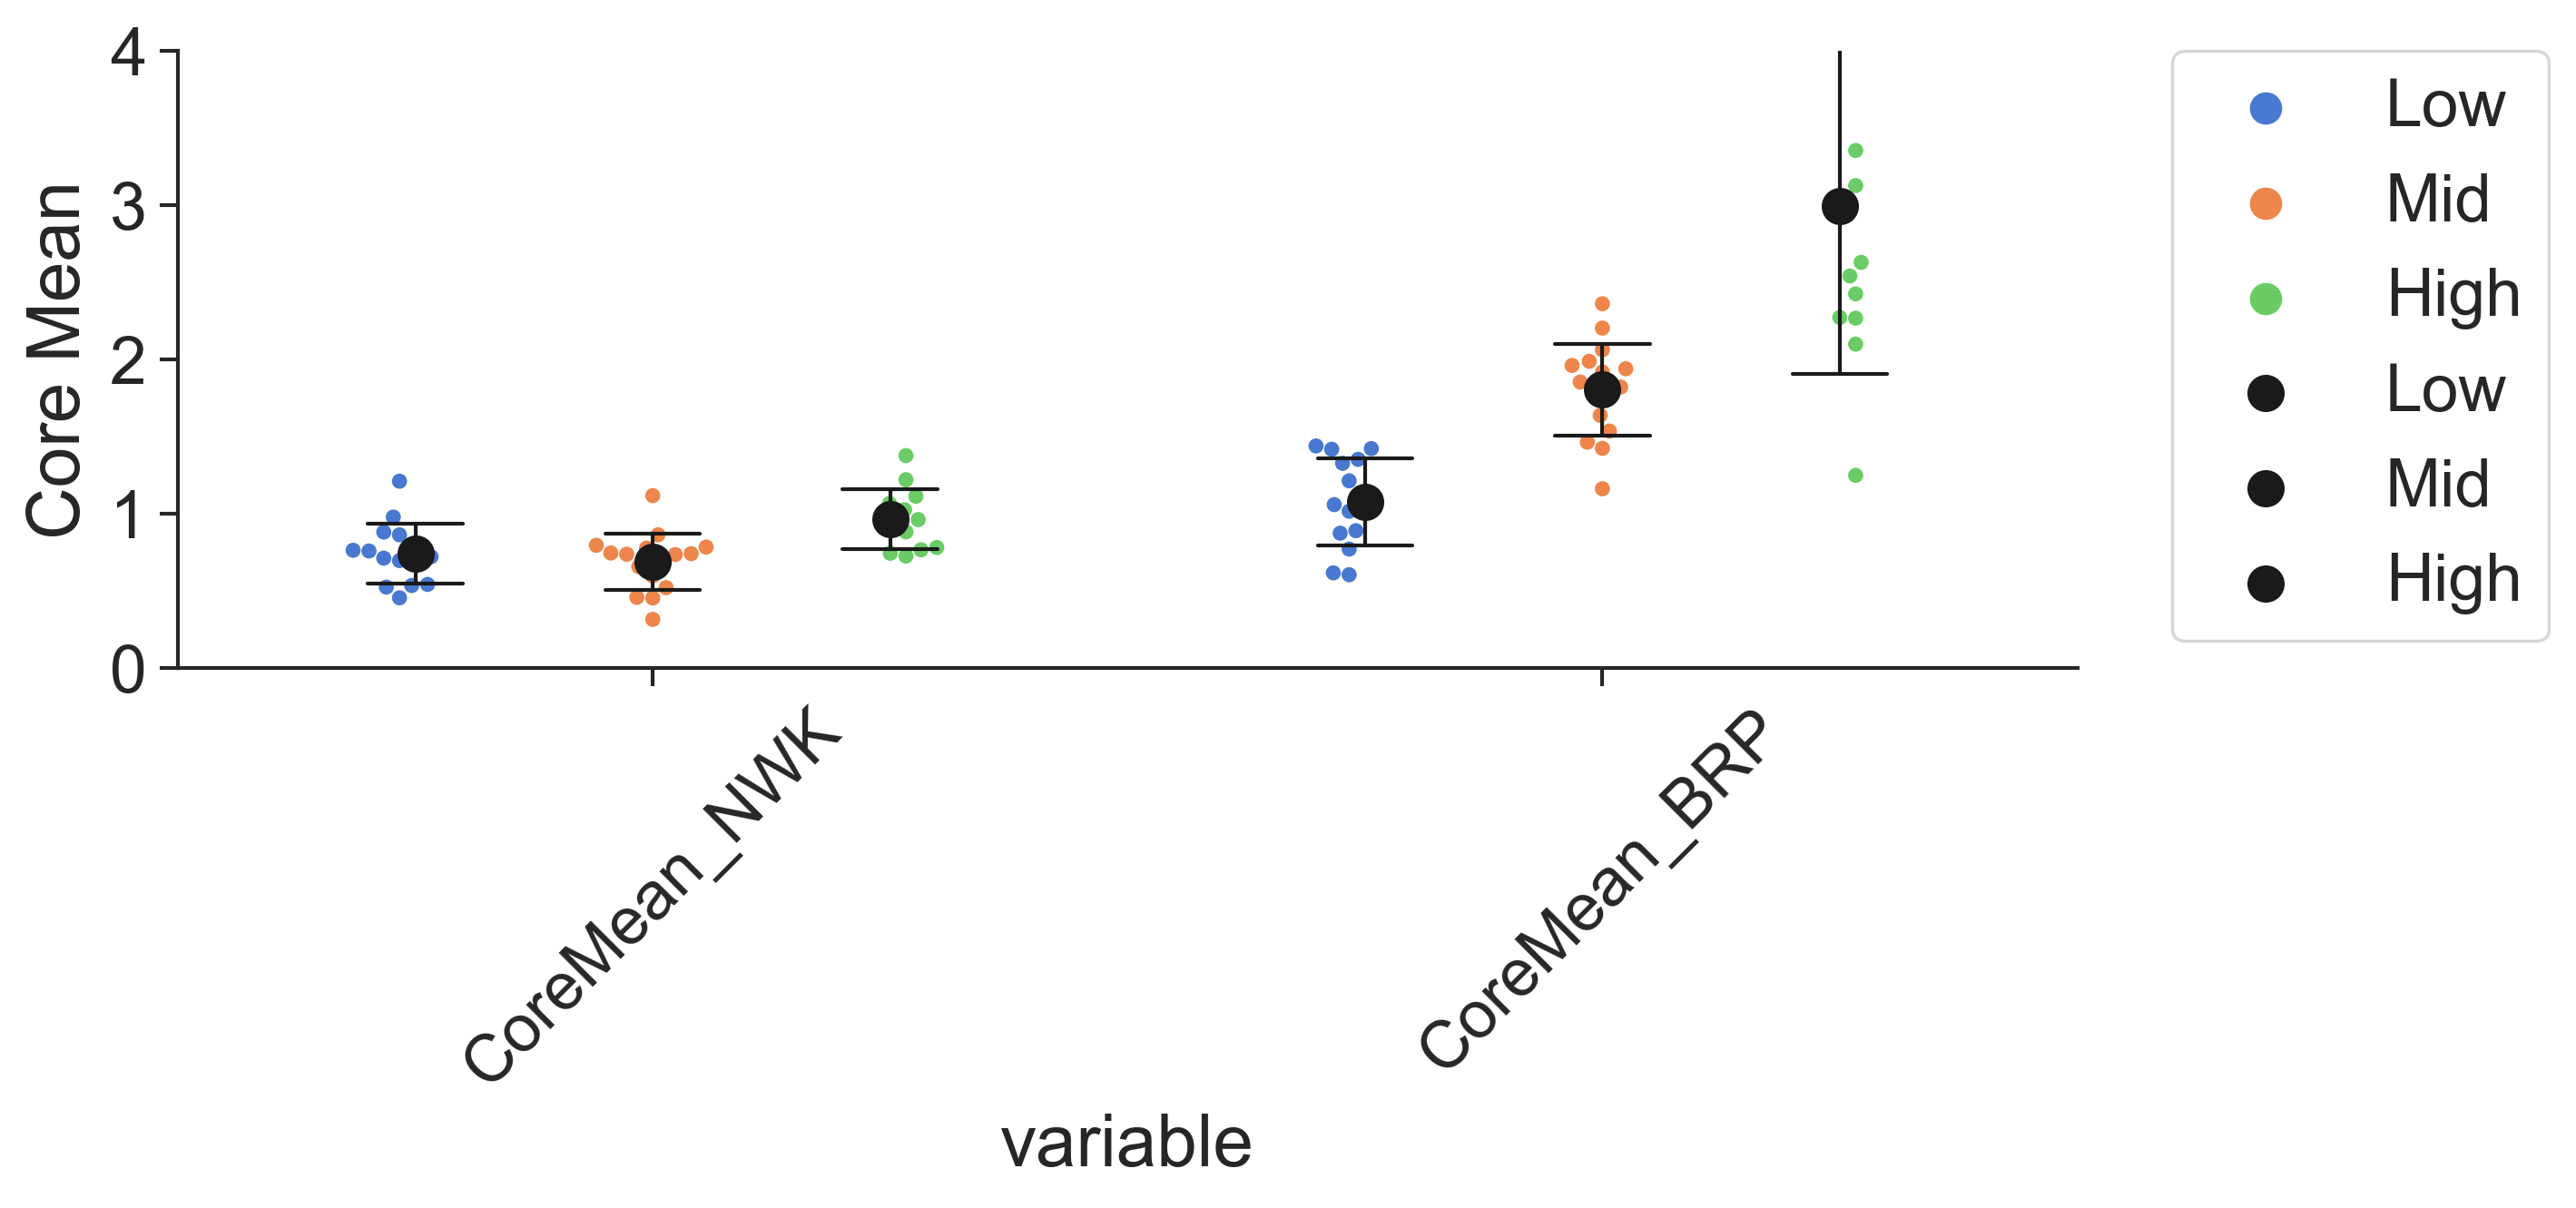

In [41]:
FIG = "Fig 4C_CoreMeanBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))

# Subset Mesh Mean data
cols = ["Experiment", "nmjid", "bins"] + [f"CoreMean_{chan}" for chan in data_order] + ["CoreMean_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Core Mean")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Core Mean")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Core Mean", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Core Mean",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [42]:
# Stats for core mean
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 29.869008068343618 p-value:3.266083683302155e-07
Performed Kruskal-Wallis: test statistic = 11.48791725992723 p-value:0.0032020673529980508


## Fig 4E Mesh Ratio by binned

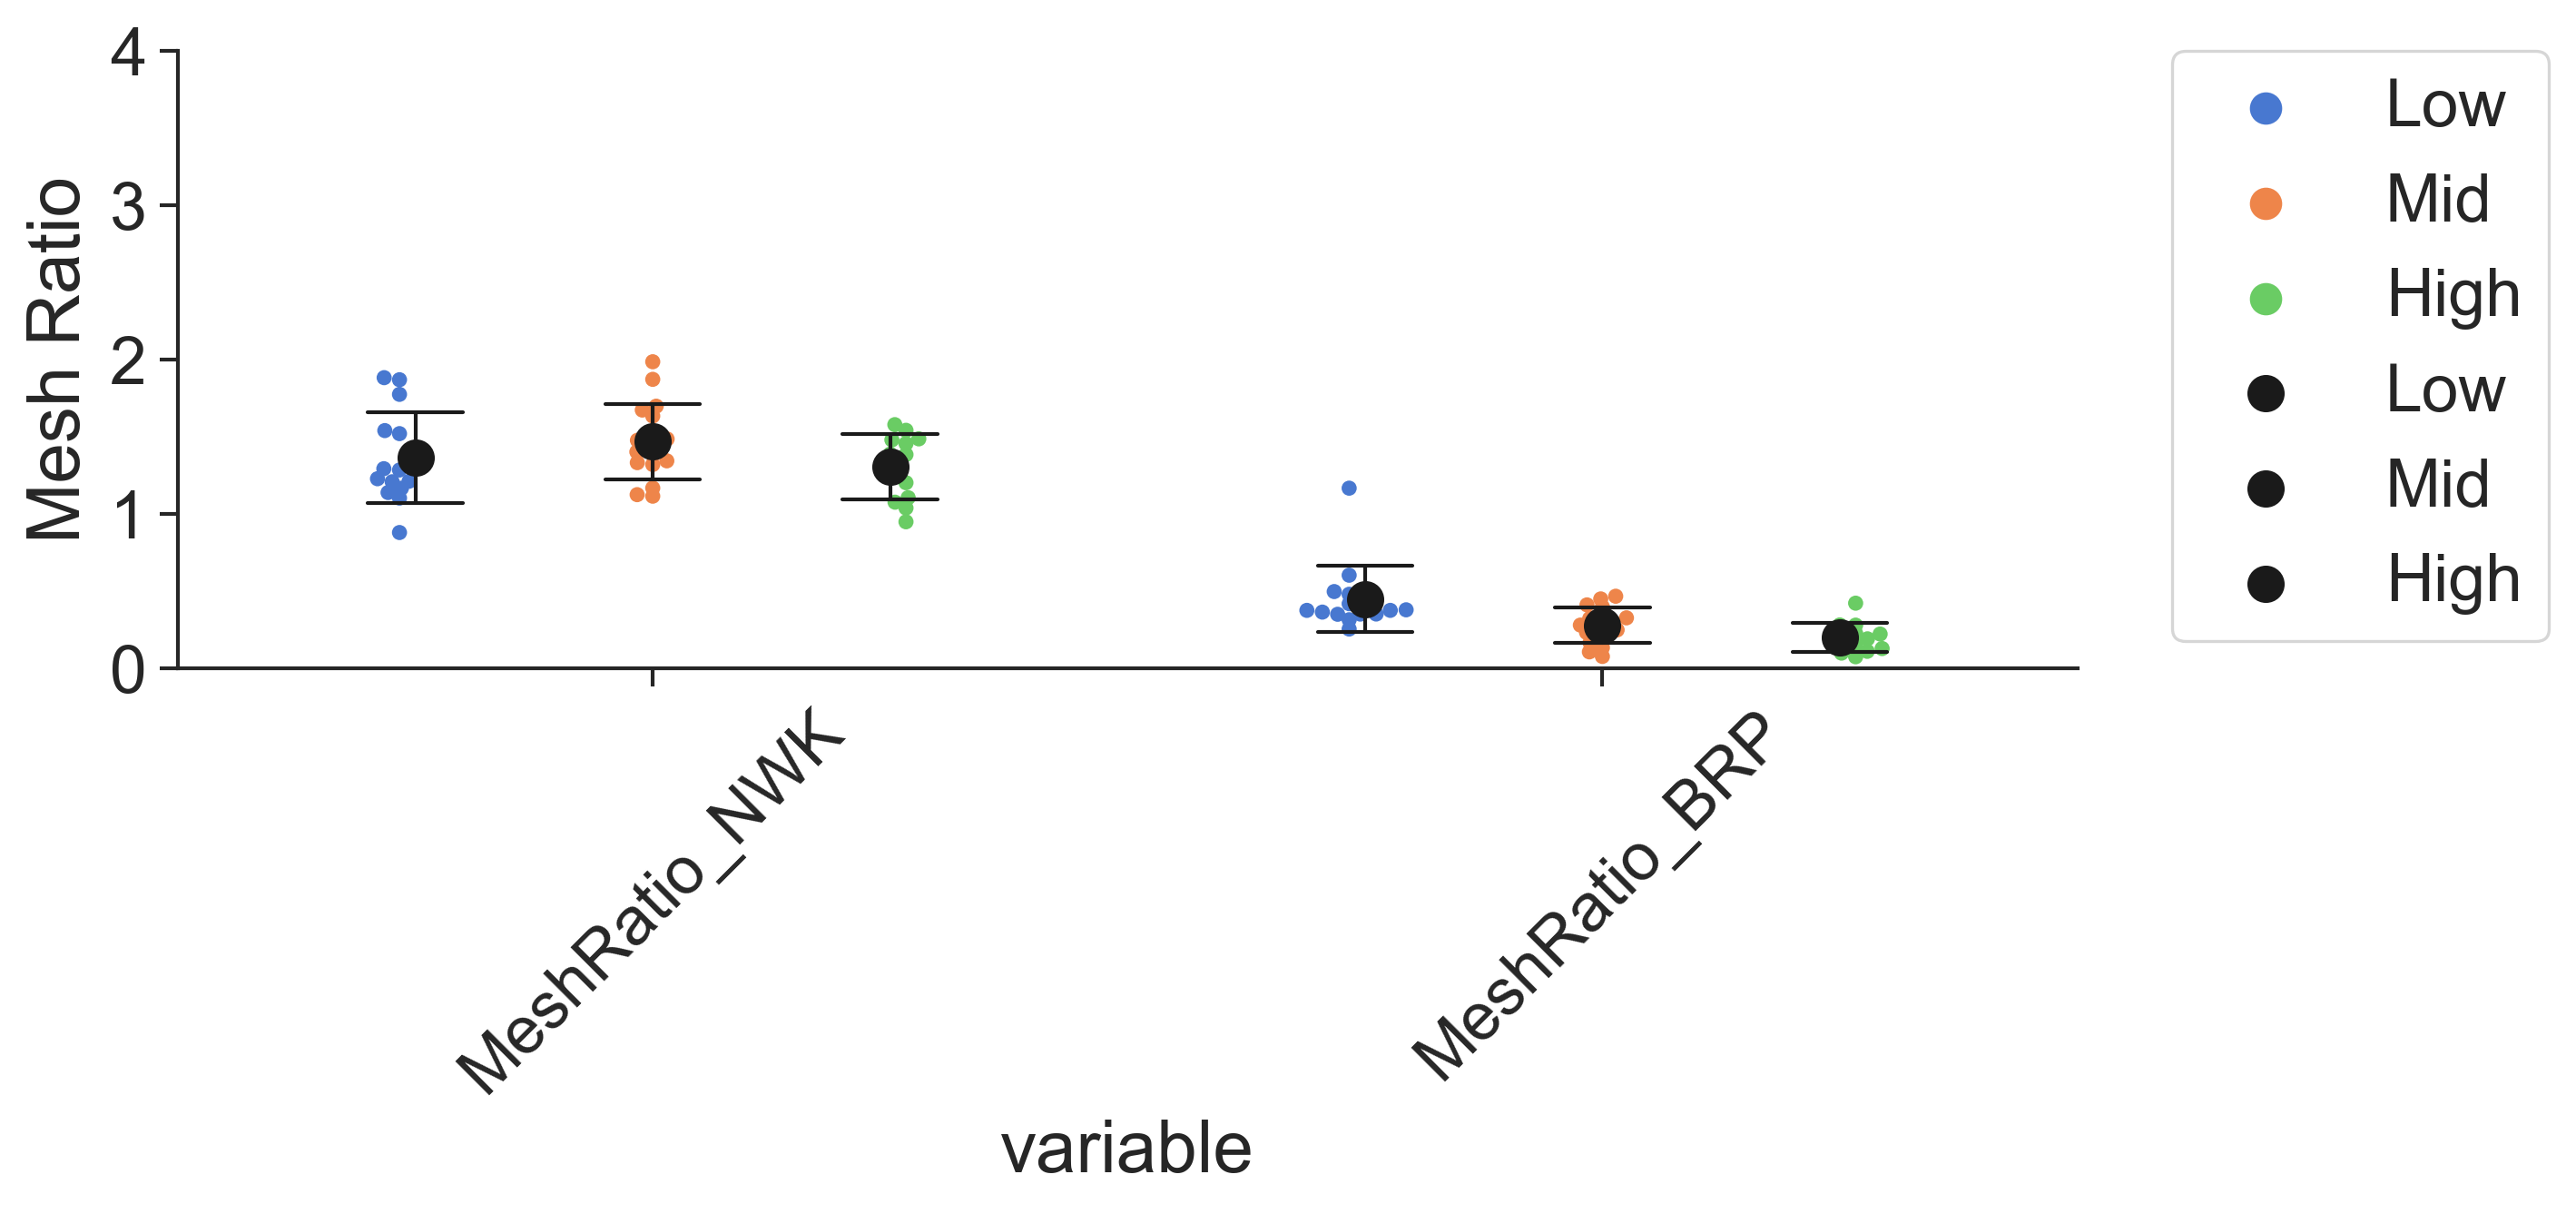

In [43]:
FIG = "Fig 4E-MeshRatioBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))

# Subset Mesh Ratio data
cols = ["Experiment", "nmjid", "bins"] + [f"MeshRatio_{chan}" for chan in data_order] + ["MeshRatio_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Mesh Ratio")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Mesh Ratio")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Mesh Ratio", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Mesh Ratio",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [ ]:
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 30.9474664646998 p-value:1.9047721947285682e-07
Performed Kruskal-Wallis: test statistic = 3.523851148851122 p-value:0.17171389738574155
Performed Kruskal-Wallis: test statistic = 6.968054773843505 p-value:0.03068358717911602
Performed Kruskal-Wallis: test statistic = 52.876710868450175 p-value:3.295855208767334e-12
Performed Kruskal-Wallis: test statistic = 25.003385988880837 p-value:3.7203493066871996e-06
Performed Kruskal-Wallis: test statistic = 0.6287900900674686 p-value:0.7302304972404077
